## Imports

In [42]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

import numpy as np
from tabulate import tabulate
import pandas as pd
import pickle
import os
import torch
import numpy as np
from sklearn import preprocessing

import torch.distributions as td

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp

import sys
sys.path.append("/home/cbarkhof/fall-2021")

BDA_MODEL_DIR = "BDA-models"
os.makedirs(BDA_MODEL_DIR, exist_ok=True)

In [43]:
from scipy import special

ALL_DF = pd.read_csv("BDA-analysis-data.csv", index_col=0)
ALL_DF["y_L0_sample_ratio"] = ALL_DF["y_L0_sample"] / (28. * 28.)
ALL_DF["y_L0_sample_log_ratio"] = np.log(ALL_DF["y_L0_sample"] / (28. * 28.))
ALL_DF["y_L0_sample_logit_ratio"] = special.logit(ALL_DF["y_L0_sample"] / (28. * 28.))
ALL_DF["mmd mean"] = ALL_DF["MMD test"] # replace this col
ALL_DF

,objective,l_rate,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name,clean_name,distortion mean,kl_prior_post mean,elbo mean,MMD test,y_L0_sample,y_L2_sample,y_KL_sample,y_L0_sample_ratio,y_L0_sample_log_ratio,y_L0_sample_logit_ratio,mmd mean
0,MDR-VAE,0.0,0.0,0,40,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...,MDR-VAE 40 dec: CNN.T,67.414677,39.488227,-106.902903,0.148580,69.0,65.980026,1.505243,0.088010,-2.430303,-2.338176,0.148580
0,MDR-VAE,0.0,0.0,0,40,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...,MDR-VAE 40 dec: CNN.T,67.414677,39.488227,-106.902903,0.148580,7.0,59.059410,0.359951,0.008929,-4.718499,-4.709530,0.148580
0,MDR-VAE,0.0,0.0,0,40,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...,MDR-VAE 40 dec: CNN.T,67.414677,39.488227,-106.902903,0.148580,19.0,75.636040,0.333165,0.024235,-3.719970,-3.695437,0.148580
0,MDR-VAE,0.0,0.0,0,40,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...,MDR-VAE 40 dec: CNN.T,67.414677,39.488227,-106.902903,0.148580,11.0,67.817955,0.160689,0.014031,-4.266514,-4.252384,0.148580
0,MDR-VAE,0.0,0.0,0,40,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...,MDR-VAE 40 dec: CNN.T,67.414677,39.488227,-106.902903,0.148580,11.0,71.190613,0.592991,0.014031,-4.266514,-4.252384,0.148580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,INFO-VAE,1000.0,0.0,0,0,100,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=1000.0, ...",INFO-VAE l_Rate 1000 l_MMD 100 dec: PixelCNN++,80.368763,0.000041,-80.368801,0.000094,56.0,58.664700,1.878116,0.071429,-2.639057,-2.564949,0.000094
75,INFO-VAE,1000.0,0.0,0,0,100,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=1000.0, ...",INFO-VAE l_Rate 1000 l_MMD 100 dec: PixelCNN++,80.368763,0.000041,-80.368801,0.000094,89.0,56.172970,2.260882,0.113520,-2.175773,-2.055275,0.000094
75,INFO-VAE,1000.0,0.0,0,0,100,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=1000.0, ...",INFO-VAE l_Rate 1000 l_MMD 100 dec: PixelCNN++,80.368763,0.000041,-80.368801,0.000094,52.0,62.154228,1.878065,0.066327,-2.713165,-2.644537,0.000094
75,INFO-VAE,1000.0,0.0,0,0,100,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=1000.0, ...",INFO-VAE l_Rate 1000 l_MMD 100 dec: PixelCNN++,80.368763,0.000041,-80.368801,0.000094,115.0,64.045074,2.086671,0.146684,-1.919477,-1.760852,0.000094


# Prepare data

In [65]:
data = dict()

# Retrieve stats for experiment groups
for group_name, group in ALL_DF.groupby("clean_name"):
    L0 = group.y_L0_sample.values
    KL = group.y_KL_sample.values
    L2 = group.y_L2_sample.values
    ELBO = group["elbo mean"].values[0]
    MMD = group["mmd mean"].values[0]
    R = group["kl_prior_post mean"].values[0]
    D = group["distortion mean"].values[0]
    run_name = group["run_name"].values[0]
    
    data[group_name] = dict(L0=L0, L2=L2, KL=KL, ELBO=ELBO, R=R, D=D, MMD=MMD, run_name=run_name)
    
# Add data group
data_space_stats = pickle.load(open("/home/cbarkhof/fall-2021/analysis/analysis-files/data_group/data_space_stats.pickle", "rb"))
L0 = np.array(data_space_stats['test']["L0_all"]) #/ (28*28)
L2 = np.array(data_space_stats['test']["L2_all"])
KNN_stats = pickle.load(open("/home/cbarkhof/fall-2021/analysis/analysis-files/data_group/knn-preds-stats.pickle", "rb"))    
KL = torch.Tensor(KNN_stats["test"]["kl_instance_marg_pred"])
KL = KL[torch.randperm(len(KL))].numpy()[:1000]

len(KL), len(L2), len(L0)
data["data_group"] = dict(L0=L0, L2=L2, KL=KL)

pd.DataFrame(data).transpose()

,L0,L2,KL,ELBO,R,D,MMD,run_name
BETA-VAE beta 0.25 dec: CNN.T,"[62.0, 73.0, 26.0, 57.0, 41.0, 45.0, 74.0, 158...","[63.80362319946289, 70.54342651367188, 76.9282...","[1.740636110305786, 1.9407898187637331, 0.5569...",-98.3561,30.6706,67.6856,0.0617708,(beta-vae-exp 6 oct) B-VAE[b=0.25] | q(z|x) in...
BETA-VAE beta 0.25 dec: PixelCNN++,"[68.0, 67.0, 66.0, 95.0, 61.0, 74.0, 128.0, 12...","[89.88079833984375, 74.05058288574219, 66.9921...","[1.7675931453704834, 2.4493300914764404, 1.096...",-89.9699,38.6658,51.304,0.0331753,(beta-vae-exp 6 oct) B-VAE[b=0.25] | q(z|x) in...
BETA-VAE beta 0.5 dec: CNN.T,"[130.0, 107.0, 91.0, 123.0, 104.0, 83.0, 156.0...","[74.344970703125, 85.83118438720703, 69.470649...","[2.214514970779419, 1.2752872705459597, 1.6267...",-94.861,25.6166,69.2445,0.0242354,(beta-vae-exp 6 oct) B-VAE[b=0.5] | q(z|x) ind...
BETA-VAE beta 0.5 dec: PixelCNN++,"[103.0, 81.0, 93.0, 141.0, 75.0, 109.0, 42.0, ...","[71.28102111816406, 93.76944732666016, 96.2115...","[2.0417680740356445, 2.0403873920440674, 1.668...",-84.6937,26.995,57.6988,0.00795209,(beta-vae-exp 6 oct) B-VAE[b=0.5] | q(z|x) ind...
BETA-VAE beta 0.75 dec: CNN.T,"[71.0, 77.0, 72.0, 141.0, 84.0, 119.0, 105.0, ...","[76.62390899658203, 80.70770263671875, 71.1851...","[2.0222530364990234, 2.601519823074341, 1.8940...",-93.1068,22.568,70.5387,0.0152655,(beta-vae-exp 6 oct) B-VAE[b=0.75] | q(z|x) in...
...,...,...,...,...,...,...,...,...
MDR-VAE 40 dec: CNN.T,"[69.0, 7.0, 19.0, 11.0, 11.0, 24.0, 15.0, 47.0...","[65.98002624511719, 59.05941009521485, 75.6360...","[1.5052433013916016, 0.35995098948478704, 0.33...",-106.903,39.4882,67.4147,0.14858,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...
MDR-VAE 40 dec: PixelCNN++,"[107.0, 52.0, 80.0, 65.0, 58.0, 54.0, 48.0, 43...","[109.16194915771484, 68.83670043945311, 75.575...","[1.4642180204391482, 1.67784321308136, 1.01982...",-92.7342,40.6984,52.0358,0.110588,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...
MDR-VAE 8 dec: CNN.T,"[57.0, 95.0, 39.0, 90.0, 242.0, 97.0, 40.0, 77...","[88.23912048339844, 72.06271362304688, 101.269...","[1.0187288522720337, 1.860348463058472, 1.9956...",-92.5928,20.5517,72.041,0.0115635,(mdr-vae-exp 8 oct) MDR-VAE[R>=8.0] | q(z|x) i...
MDR-VAE 8 dec: PixelCNN++,"[144.0, 80.0, 142.0, 95.0, 105.0, 120.0, 94.0,...","[67.80252075195311, 54.56437301635742, 59.7959...","[2.174213409423828, 1.323405623435974, 2.50536...",-80.2394,7.88576,72.3536,0.00138736,(mdr-vae-exp 8 oct) MDR-VAE[R>=8.0] | q(z|x) i...


In [62]:
class DPMixture:
    def __init__(self, group_names: list, observations: list, obs_dist="normal",
                 DP_alpha=1., num_comps=5,
                 num_samples=1000, num_chains=1, num_warmup=100):

        self.DP_alpha = DP_alpha
        self.T = num_comps
        
        self.obs_dist = obs_dist
        
        # [G]
        self.group_names = group_names
        self.G = len(group_names)
        
        self.group_name_to_id = {n:i for i, n in enumerate(group_names)}
        self.group_id_to_name = {i:n for i, n in enumerate(group_names)}
        
        self.N = sum(len(y) for y in observations)
        
        # [N]
        self.obs_g = np.concatenate([[g] * len(y) for g, y in enumerate(observations)])
        self.obs_y = np.concatenate(observations)
        
        #print("obs g shape", self.obs_g.shape)
        #print("obs y shape", self.obs_y.shape)

        self.num_samples = num_samples
        self.num_chains = num_chains
        self.num_warmup = num_warmup

        self.rng_key = random.PRNGKey(0)

        nuts_kernel = NUTS(self.model)
        self.mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)

        self.prior_predictive = None
        self.posterior_predictive = None
        self.posterior_samples = None

    @classmethod
    def mix_weights(cls, beta):
        beta1m_cumprod = (1 - beta).cumprod(-1)
        return jnp.pad(beta, ((0, 0), (0, 1)), constant_values=1) * jnp.pad(beta1m_cumprod, ((0, 0), (1, 0)), constant_values=1)

    @classmethod
    def stick_break_sorting(cls, beta):
        beta1m_cumprod = (1 - beta).cumprod(-1)
        return jnp.pad(beta, (0, 1), constant_values=1) * jnp.pad(beta1m_cumprod, (1, 0), constant_values=1)
    
    def model(self, y=None):
        """
        Pyro joint distribution.
        
        Parameter:
        
        y: observations as returned by self.prepare or None. 
            If None, the 'obs' node of the graphical model will be resampled.
        """

        N, G, T = self.N, self.G, self.T
        
        loc, scale, df = 0.0, 0.0, 0.0
        
        # Components
        with numpyro.plate("components", T):  
            if self.obs_dist == "binomial":
                lamb = numpyro.sample("lamb", dist.Beta(1.0, 1.0))
#                 probs = numpyro.deterministic("probs", jnp.cumprod(lamb, axis=-1))
                probs = numpyro.deterministic("probs", self.stick_break_sorting(lamb))
#                 probs = numpyro.deterministic("probs", jnp.sort(lamb, axis=-1))
                # probs = jnp.sort(probs, axis=-1)
            
            # loc & scale for log normal, normal and student T
            if "normal" in self.obs_dist or self.obs_dist == "student_t":
                if self.obs_dist == "log_normal":
                    mean = 0.0
                else:
                    mean = np.mean(self.obs_y)
                
                loc = numpyro.sample('loc', dist.Normal(mean, 1.0))
                print("loc.shape", loc.shape)
                idx = jnp.argsort(loc, -1) #, -1
                loc = loc[idx]
                
                scale = numpyro.sample('scale', dist.Gamma(1, 10))
#                 scale = scale[idx]
                
            # degrees of freedom
            if self.obs_dist == "student_t":
                df = numpyro.sample("student_df", dist.Exponential(rate=1.0 / 10.0))
#                 df = df[idx]
            
        
        # Sample mixing weights    
        with numpyro.plate("DPs", G):
            # [G, T-1]
            beta = numpyro.sample("beta", dist.Beta(np.ones(1), np.ones(1) * self.DP_alpha).expand((T-1,)).to_event(1))
        
        # [G, T]
        omega = numpyro.deterministic("omega", self.mix_weights(beta))
        
        loc_z, scale_z, df_z = 0.0, 0.0, 0.0
        with numpyro.plate("observations", N):
            # Choose component
            z = numpyro.sample("z", dist.Categorical(probs=omega[self.obs_g])) 
            
            if "normal" in self.obs_dist or self.obs_dist == "student_t":
                loc_z = numpyro.deterministic("loc_z", loc[z])
                scale_z = numpyro.deterministic("scale_z", scale[z])
            
            if self.obs_dist == "student_t":
                df_z = numpyro.deterministic("df_z", df[z])
                
            if self.obs_dist == "binomial":
                probs_z = numpyro.deterministic("probs_z", probs[z])
            
            # Construct the likelihood function 
            if self.obs_dist == "normal":
                sampled_y = numpyro.sample("y", dist.Normal(loc=loc_z, scale=scale_z), obs=y)
            
            elif self.obs_dist == "log_normal":
                sampled_y = numpyro.sample("y", dist.LogNormal(loc=loc_z, scale=scale_z), obs=y)
            
            elif self.obs_dist == "student_t":
                sampled_y = numpyro.sample("y", dist.StudentT(loc=loc_z, scale=scale_z, df=df_z), obs=y)
            
            elif self.obs_dist == "binomial":
                sampled_y = numpyro.sample("y", dist.Binomial(probs=probs_z, total_count=28*28), obs=y)
            
            elif self.obs_dist == "truncated_normal":
                sampled_y = numpyro.sample("y", dist.TruncatedNormal(low=0.0, loc=loc_z, scale=scale_z), obs=y)
            
            else:
                raise NotImplementedError
            
            #print("sampled y", sampled_y.shape)
            
            return sampled_y

    def run(self):
        self.mcmc.run(self.rng_key, y=self.obs_y)
        self.mcmc.print_summary()
        self.posterior_samples = self.mcmc.get_samples(group_by_chain=False)
        print("posterior samples shapes:")
        for k, v in self.posterior_samples.items():
            print(k, v.shape)

    def make_prior_predictive(self, num_prior_samples=100):        
        if self.prior_predictive is None:
            self.prior_predictive = Predictive(self.model, num_samples=num_prior_samples)

    def draw_prior_predictions(self):
        if self.prior_predictive is None:
            self.make_prior_predictive()
        rng_key, rng_key_ = random.split(self.rng_key)        
        return self.prior_predictive(rng_key_, y=None)["y"]

    def make_posterior_predictive(self):
        if self.posterior_samples is None:
            raise RuntimeError("You need to run the sampler first")        
        if self.posterior_predictive is None:
            self.posterior_predictive = Predictive(self.model, self.posterior_samples)        

    def draw_posterior_predictions(self, plot=False):
        if self.posterior_predictive is None:
            self.make_posterior_predictive()        
        rng_key, rng_key_ = random.split(self.rng_key)
        return self.posterior_predictive(rng_key_, y=None)["y"]
    

In [63]:
def plot_all_groups_preds_obs(self):
    post_preds = dp_mixture_model.draw_posterior_predictions()

    N_groups = len(self.group_names)

    ncols = 5
    nrows = int(np.ceil(N_groups / 5))

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3*ncols, 2*nrows))

    for g in range(N_groups):
        row, col = g // ncols, g % ncols

        preds_g = post_preds[:, self.obs_g == g]
        obs_g = self.obs_y[self.obs_g == g]

        axs[row, col].hist(np.array(preds_g).flatten(), bins=40, density=True, lw=0, label="preds", alpha=0.7, color="blue")
        axs[row, col].hist(np.array(obs_g).flatten(), bins=40, density=True, lw=0, label="obs", alpha=0.7, color="lightblue")

        axs[row, col].set_title(self.group_names[g], size=8)

        if (col == ncols-1) and (row == 0):
            axs[row, col].legend(loc=(1.05, 0.8))

    plt.tight_layout()
    plt.show()

def plot_model_data_preds_obs(self):
    post_preds = dp_mixture_model.draw_posterior_predictions()

    ncols = 3
    nrows = 1

    c_dict = {
        "data preds": "green",
        "data obs": "lightgreen",
        "model preds": "blue",
        "model obs": "lightblue"
    }

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols, 3*nrows))

    data_group_id = self.group_names.index("data_group")

    preds_model_groups = post_preds[:, self.obs_g != data_group_id]
    obs_model_groups = dp_mixture_model.obs_y[self.obs_g != data_group_id]

    preds_data_group = post_preds[:, self.obs_g == data_group_id]
    obs_data_group = dp_mixture_model.obs_y[self.obs_g == data_group_id]

    axs[0].hist(np.array(preds_model_groups).flatten(), bins=40, density=True, lw=0, label="model preds", color=c_dict["model preds"], alpha=0.7)
    axs[0].hist(np.array(obs_model_groups).flatten(), bins=40, density=True, lw=0, label="model obs", color=c_dict["model obs"], alpha=0.7)
    axs[0].hist(np.array(preds_data_group).flatten(), bins=40, density=True, lw=0, label="data preds", color=c_dict["data preds"], alpha=0.7)
    axs[0].hist(np.array(obs_data_group).flatten(), bins=40, density=True, lw=0, label="data obs", color=c_dict["data obs"], alpha=0.7)

    axs[1].hist(np.array(preds_data_group).flatten(), bins=40, density=True, lw=0, label="data preds", color=c_dict["data preds"], alpha=0.7)
    axs[1].hist(np.array(obs_data_group).flatten(), bins=40, density=True, lw=0, label="data obs", color=c_dict["data obs"], alpha=0.7)

    axs[2].hist(np.array(preds_model_groups).flatten(), bins=40, density=True, lw=0, label="model preds", color=c_dict["model preds"], alpha=0.7)
    axs[2].hist(np.array(obs_model_groups).flatten(), bins=40, density=True, lw=0, label="model obs", color=c_dict["model obs"], alpha=0.7)

    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    axs[0].set_title("Model and data groups obs & preds")
    axs[1].set_title("Data group obs & preds")
    axs[2].set_title("Model group obs & preds")

    plt.tight_layout()
    plt.show()
    


def plot_component_dist_and_data_group_distance(self, mmds=None):
    # [N_s, N_g, N_c]
    omega = self.posterior_samples["omega"] 
    data_group_id = self.group_names.index("data_group")
    omega_data_group = omega[:, data_group_id, :]

    omega_tensor = torch.FloatTensor(np.array(omega))
    omega_data_group_tensor = torch.FloatTensor(np.array(omega_data_group)).unsqueeze(1)
    
    omega_dists = td.Categorical(probs=omega_tensor)
    omega_data_group_dists = td.Categorical(probs=omega_data_group_tensor)
    
    # [N_s, N_g, N_c] -> [N_s, N_g] -> [N_g]
    kl = td.kl_divergence(omega_data_group_dists, omega_dists)
    kl_avg = kl.mean(axis=0) # avg sample dim
    
    kl_order = np.argsort(kl_avg.numpy().flatten())
    labels_reorder = np.array(self.group_names)[kl_order]

    x = np.arange(len(kl_order))

    fig, ax = plt.subplots(figsize=(14, 6))
    
    if mmds is None:
        ax.bar(x, kl_avg[kl_order], 0.4, lw=0, label="KL div.")
    else:
        mmds_reorder = np.array(mmds)[kl_order]
        _ = ax.bar(x-0.2, kl_avg[kl_order], 0.4, lw=0, label="KL div.")
        _ = ax.bar(x+0.2, mmds_reorder, 0.4, lw=0, label="MMD")

    ax.set_xticks(x)
    ax.set_xticklabels(labels_reorder)

    ax.tick_params(axis='both', labelsize=8)

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    plt.legend()
    _ = plt.suptitle(f"KL of experiment groups component assignments to data group component assignment")
    plt.show()
    

# L0

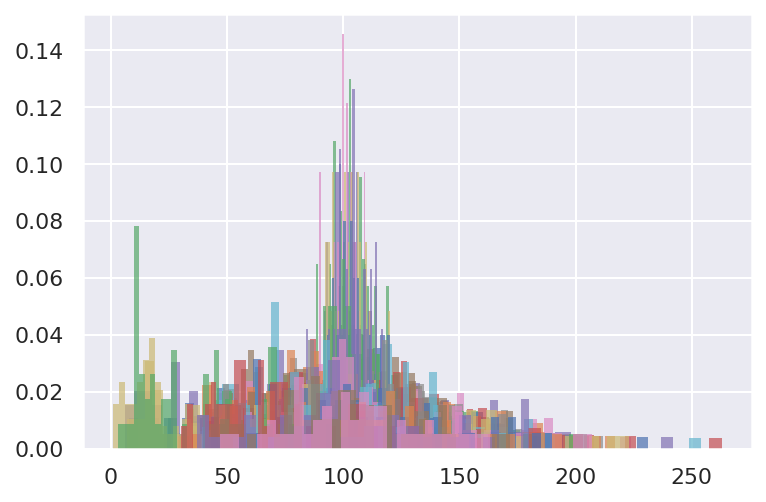

Loading model from file BDA-models/binomial_L0_dp_mixture_model.p


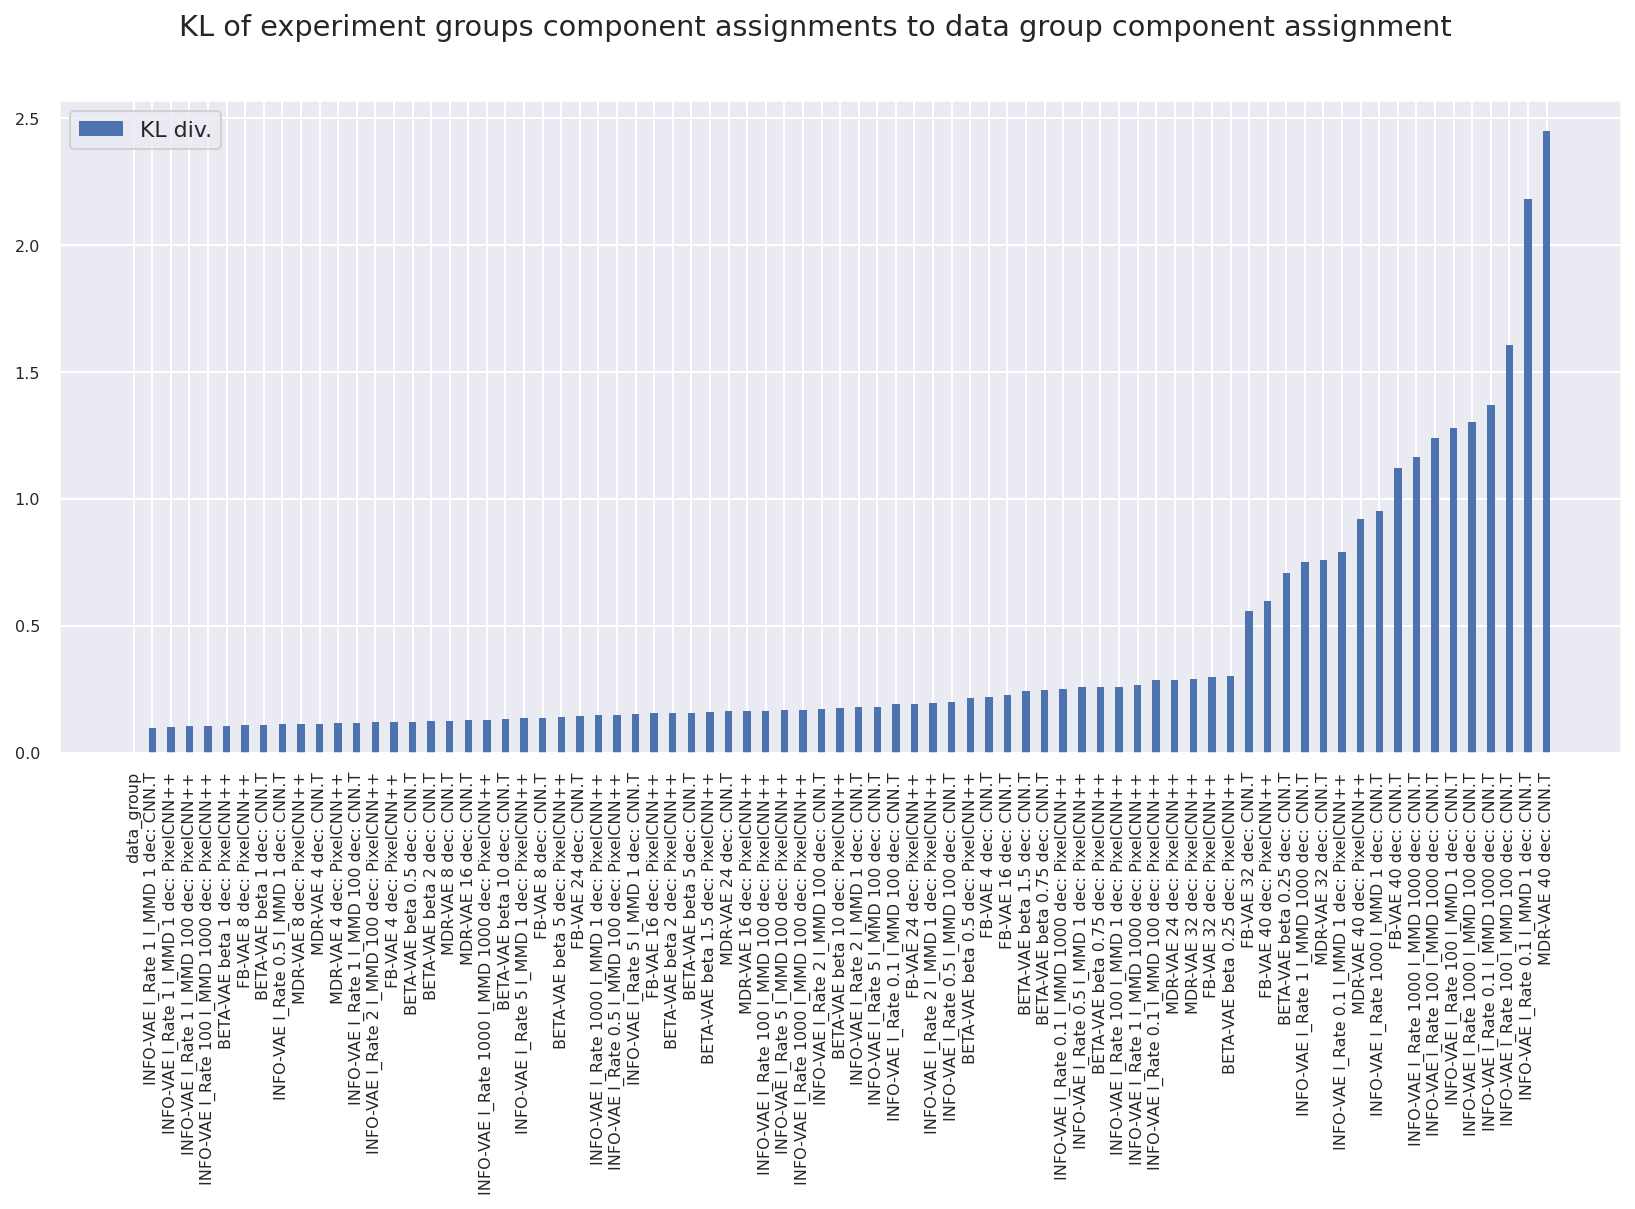

loc.shape (5,)


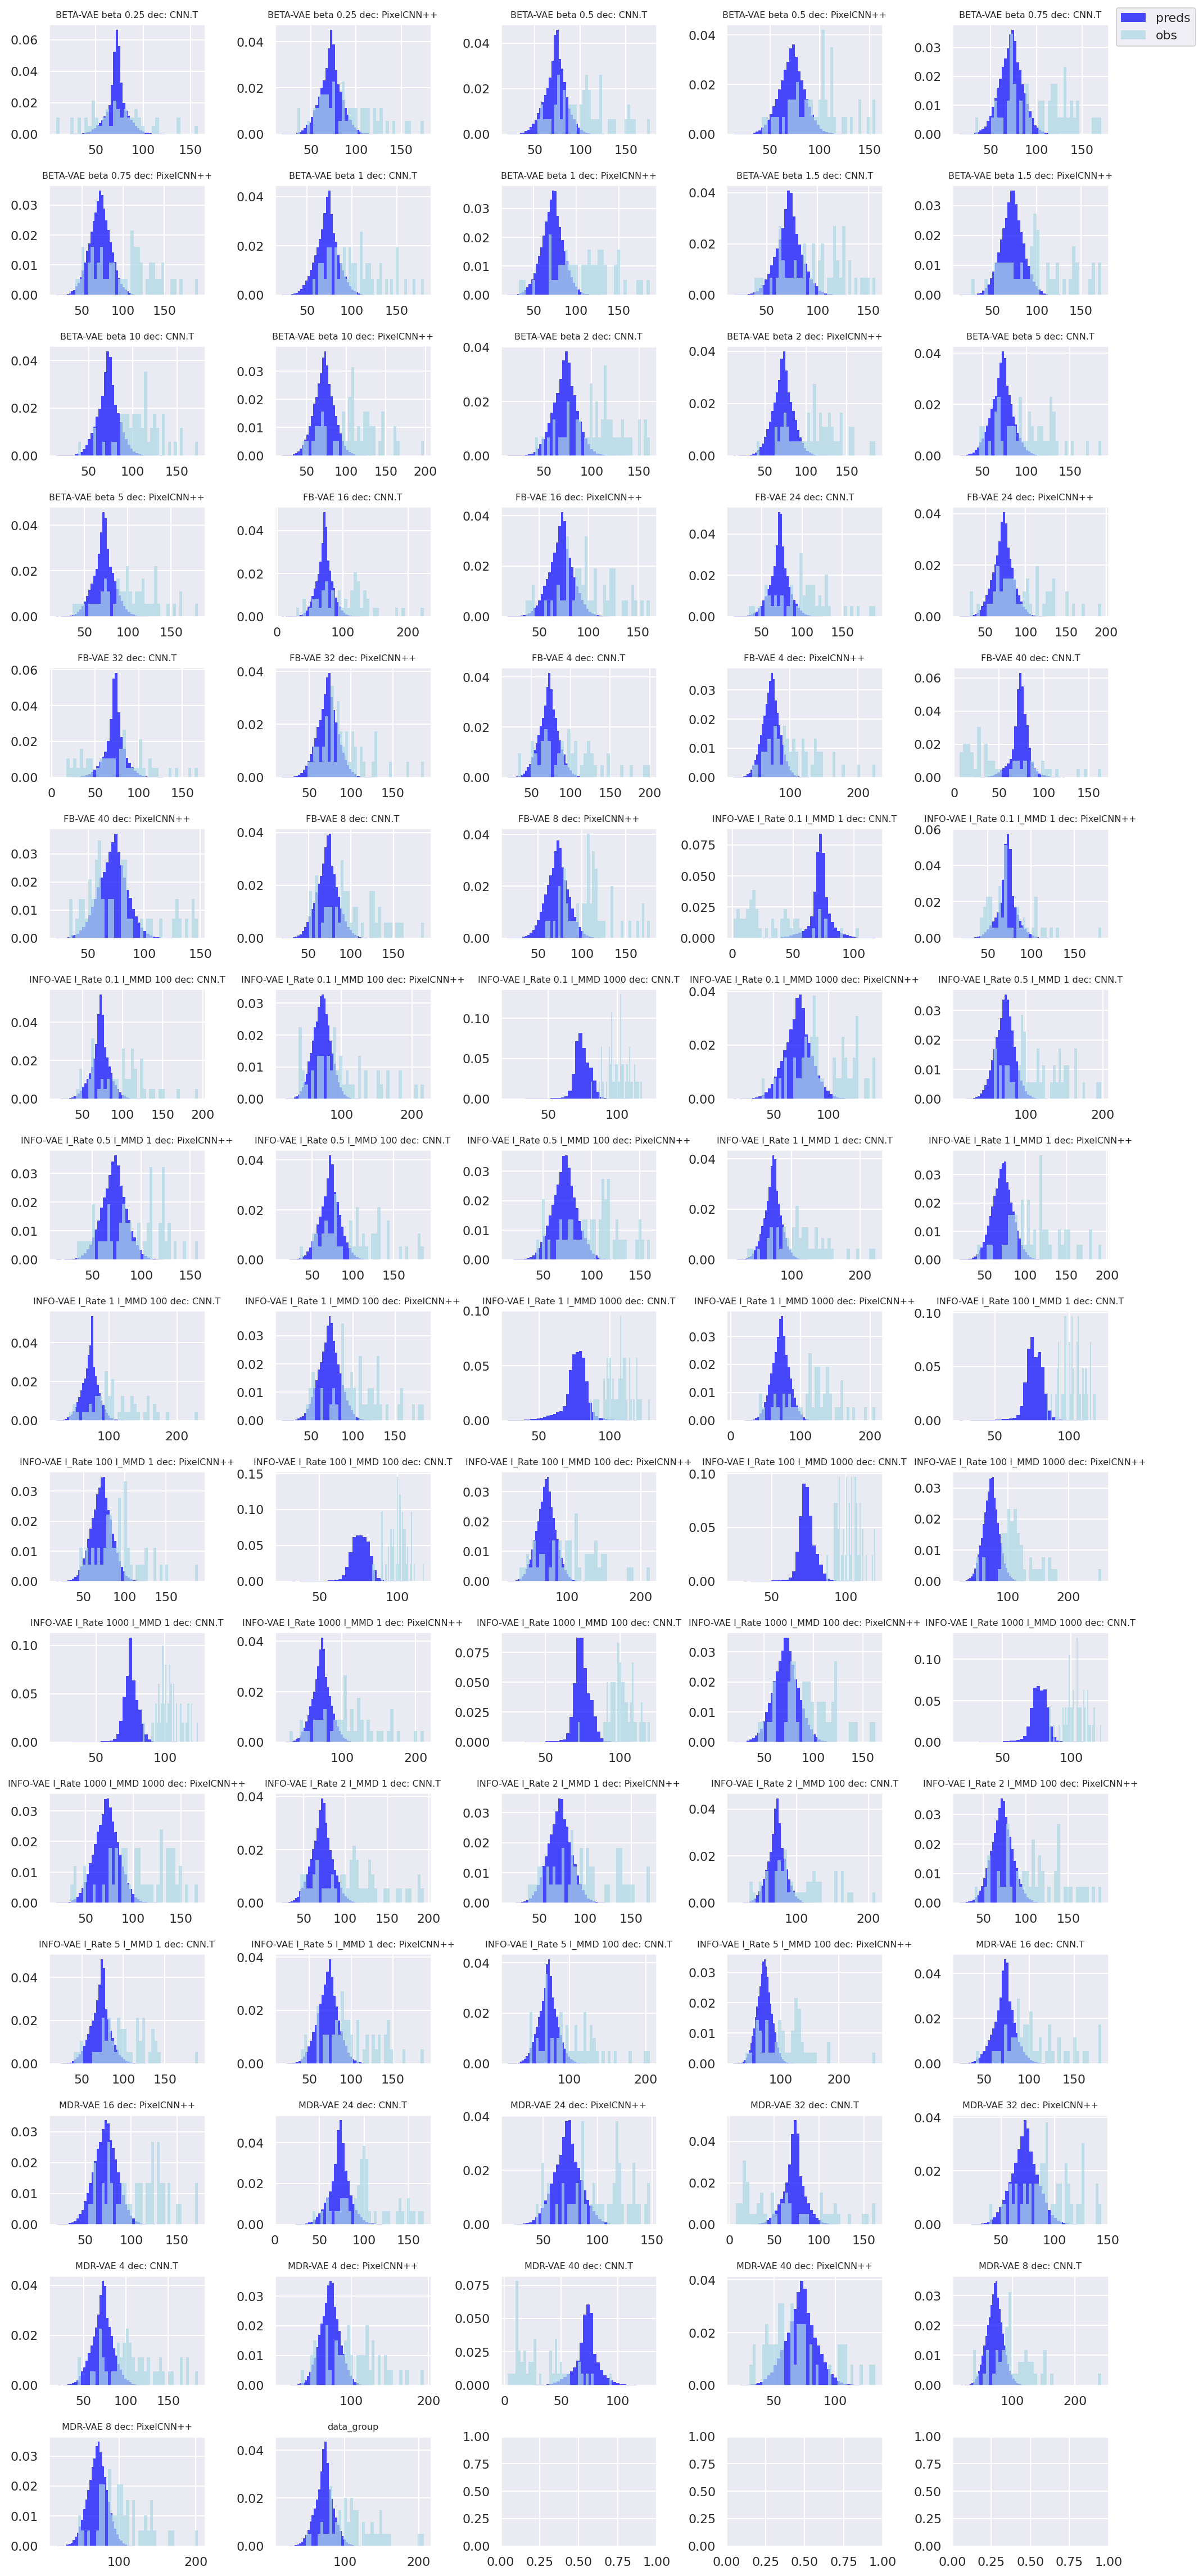

loc.shape (5,)


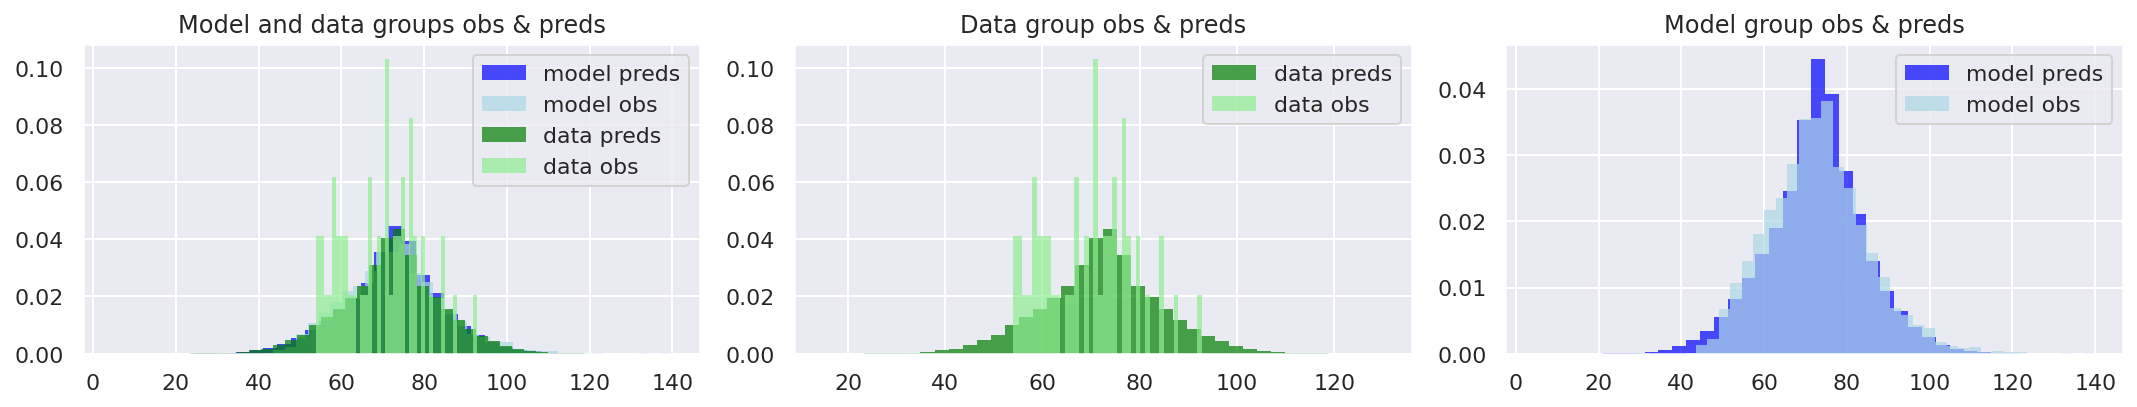

In [67]:
STAT = "L0"
DIST = "binomial"
SAVE_FILE = f"{BDA_MODEL_DIR}/{DIST}_{STAT}_dp_mixture_model.p"
RUN = False
MAX_POINTS_PER_GROUP = 50

# 1 Prepare data
group_names, observations, mmds, elbos = [], [], [], []
for k, v in data.items():
    group_names.append(k)
    observations.append(v[STAT][:MAX_POINTS_PER_GROUP])
    if k == "data_group":
        mmds.append(0)
        elbos.append(0)
    else:
        mmds.append(v["MMD"])
        elbos.append(-v["ELBO"])

# 2 Plot data
for (g, o) in zip(group_names, observations):
    plt.hist(o, label=g, alpha=0.7, bins=40, density=True, lw=0)
plt.show()

# 3 Run MCMC
if RUN or not os.path.isfile(SAVE_FILE):
    print("Running from scratch")
    dp_mixture_model_l0 = DPMixture(group_names, 
                                 observations, 
                                 obs_dist=DIST, 
                                 DP_alpha=1., 
                                 num_comps=5, 
                                 num_samples=1000, 
                                 num_chains=1, 
                                 num_warmup=100)
    dp_mixture_model_l0.run()
    pickle.dump(dp_mixture_model_l0, open(SAVE_FILE, "wb"))
else:
    print(f"Loading model from file {SAVE_FILE}")
    dp_mixture_model_l0 = pickle.load(open(SAVE_FILE, "rb"))
    
# 4 Plot results
plot_component_dist_and_data_group_distance(dp_mixture_model_l0)
plot_all_groups_preds_obs(dp_mixture_model_l0)
plot_model_data_preds_obs(dp_mixture_model_l0)

# KL

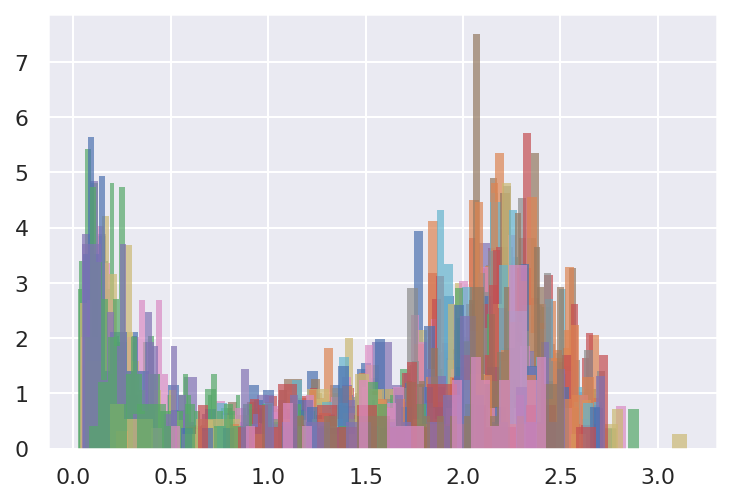

Loading model from file BDA-models/truncated_normal_KL_dp_mixture_model.p


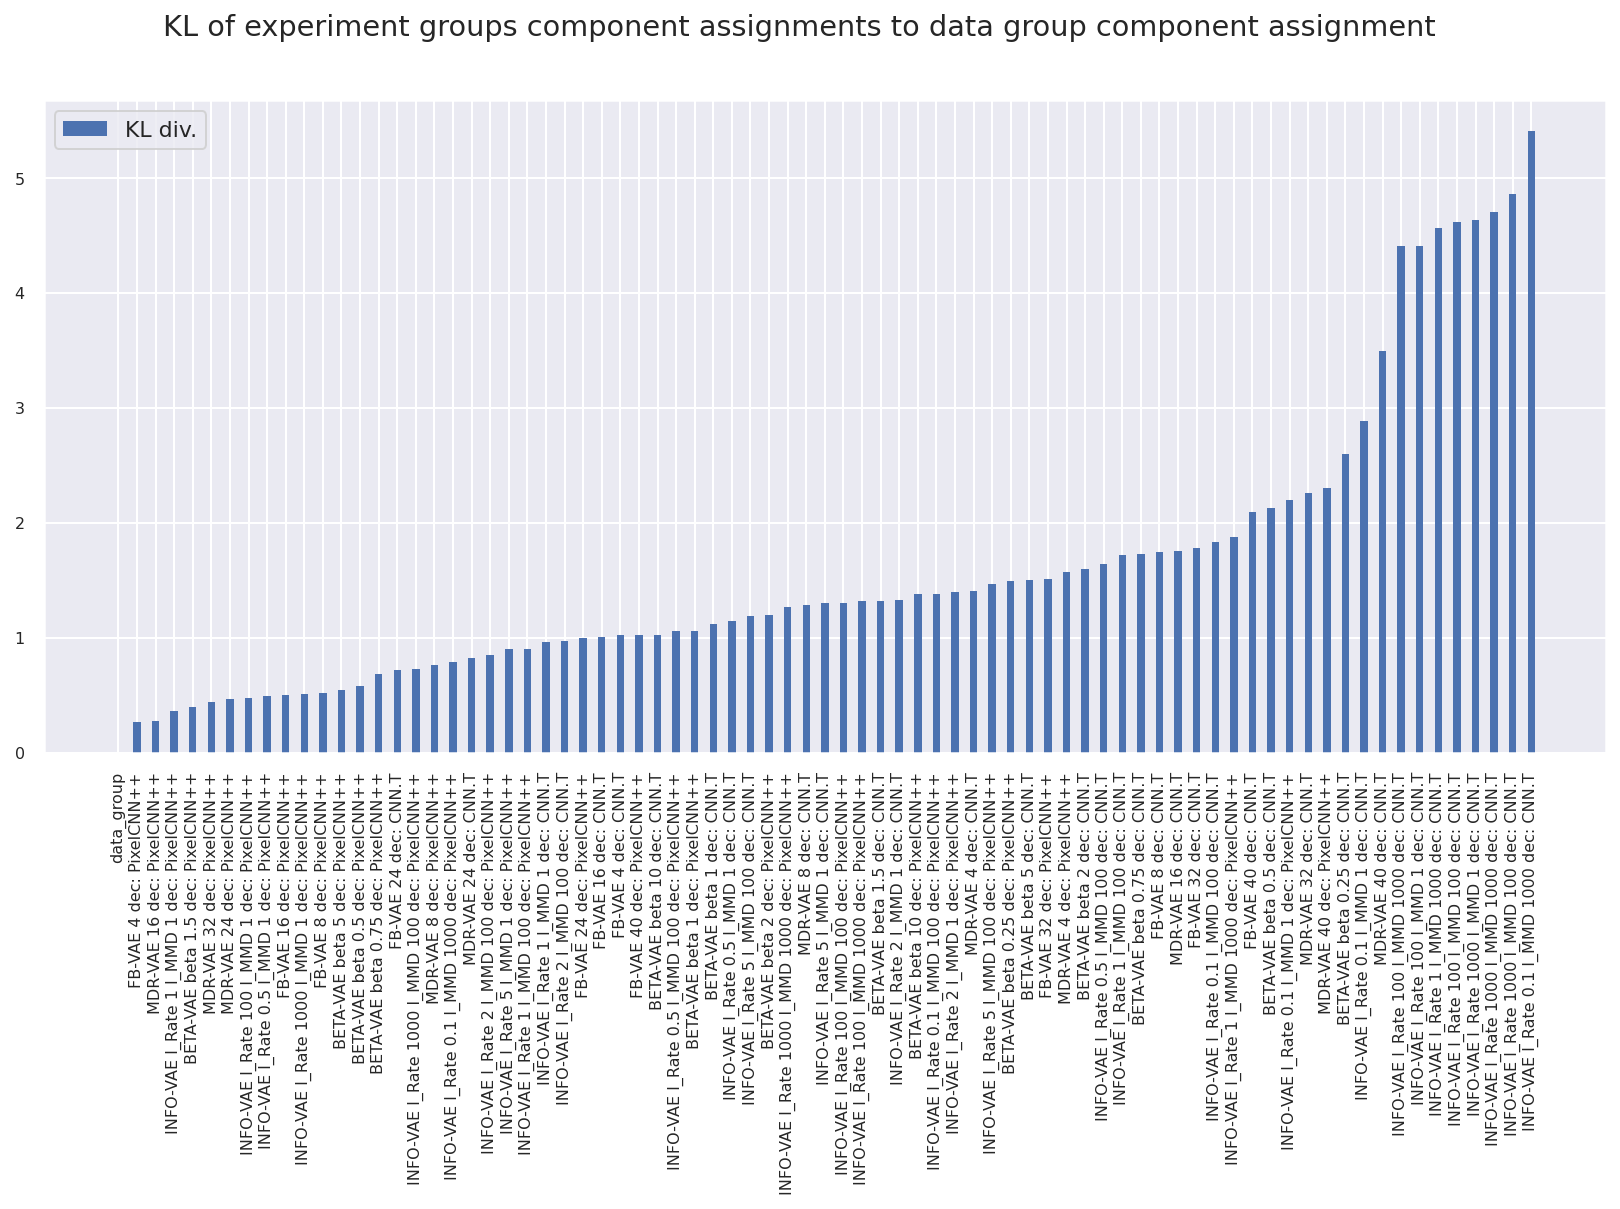

loc.shape (5,)


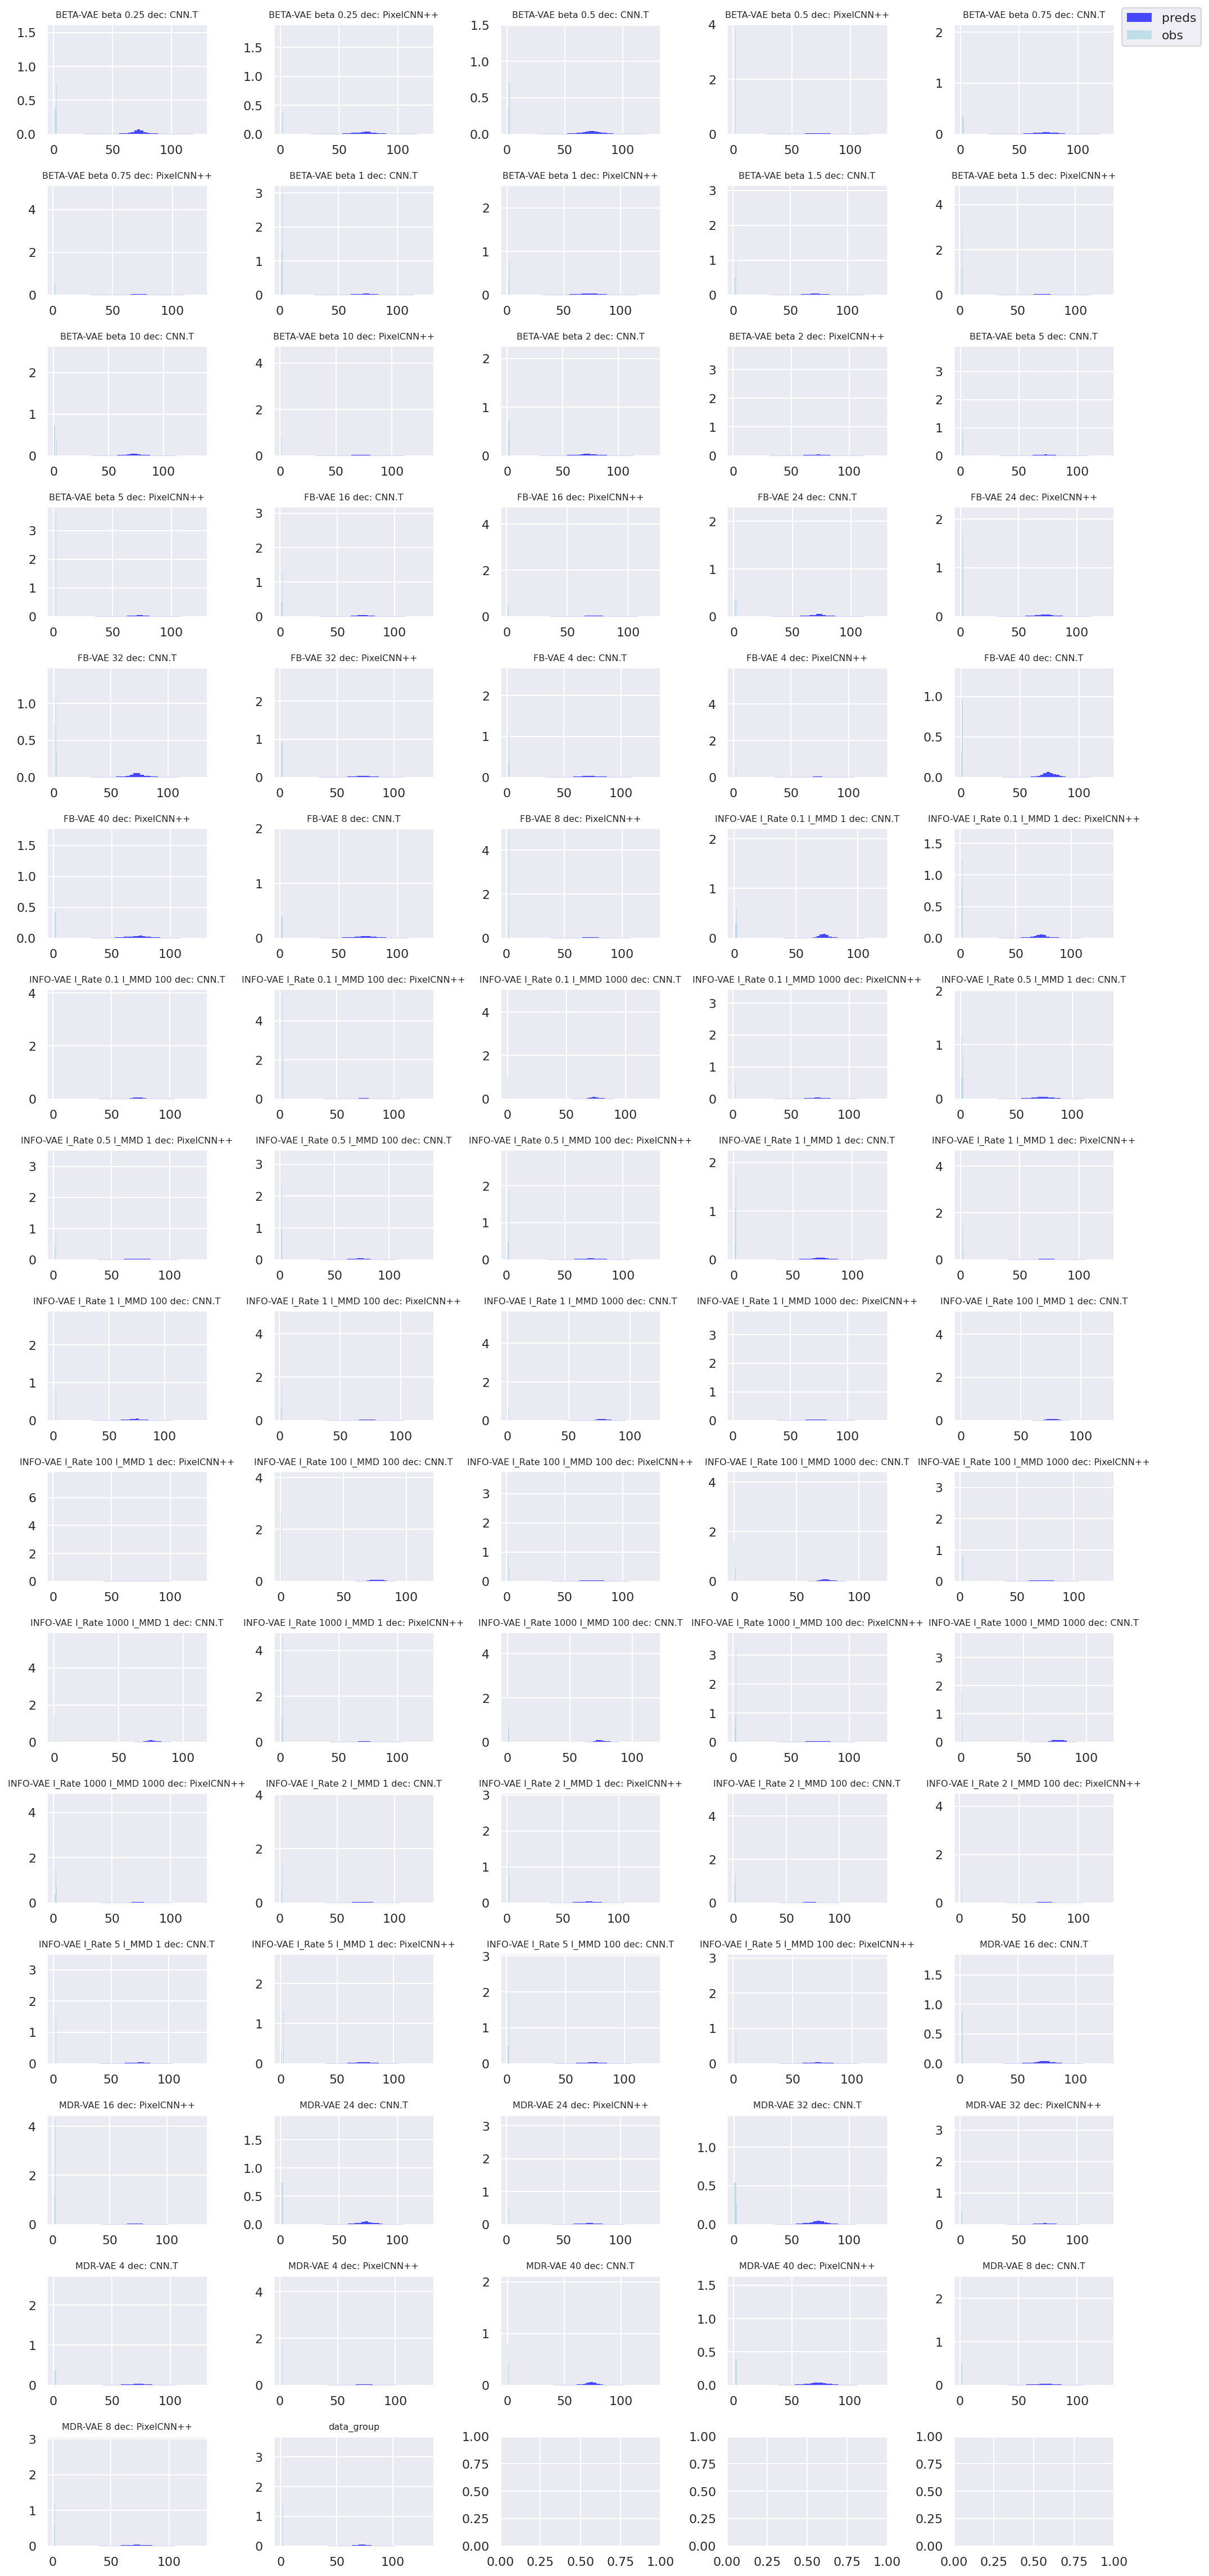

loc.shape (5,)


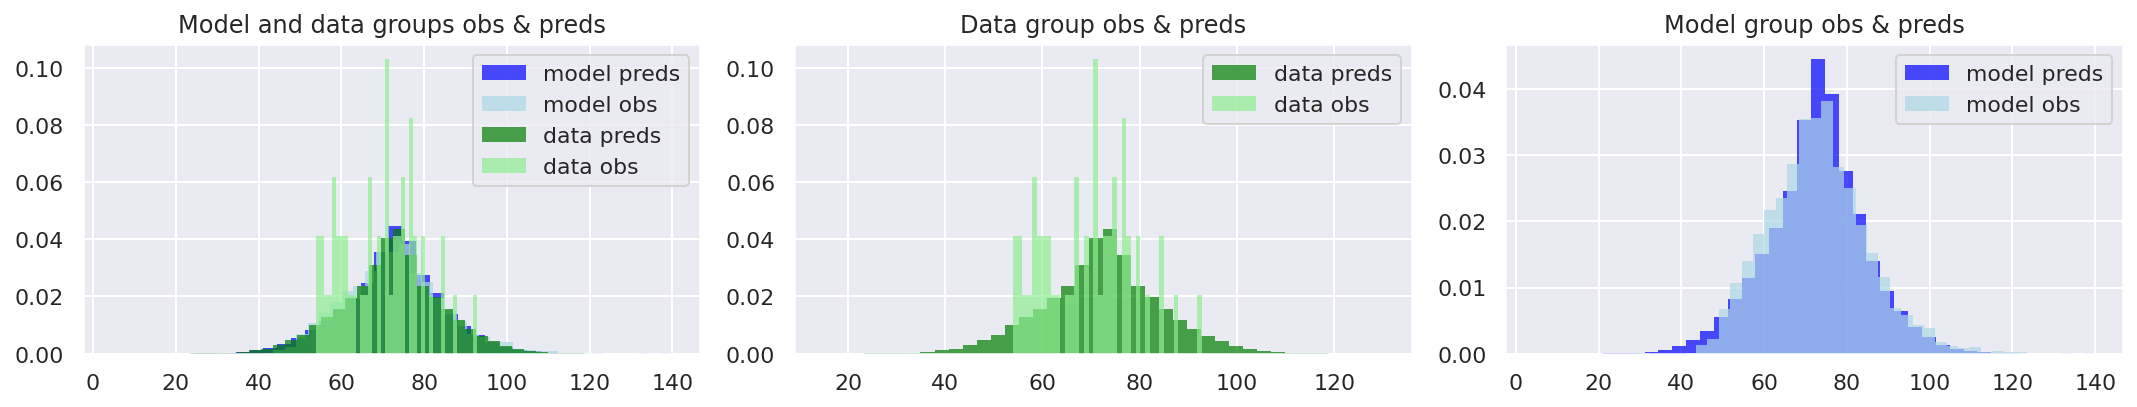

In [68]:
STAT = "KL"
DIST = "truncated_normal"
SAVE_FILE = f"{BDA_MODEL_DIR}/{DIST}_{STAT}_dp_mixture_model.p"
RUN = False
MAX_POINTS_PER_GROUP = 50

# 1 Prepare data
group_names, observations, mmds, elbos = [], [], [], []
for k, v in data.items():
    group_names.append(k)
    observations.append(v[STAT][:MAX_POINTS_PER_GROUP])
    if k == "data_group":
        mmds.append(0)
        elbos.append(0)
    else:
        mmds.append(v["MMD"])
        elbos.append(-v["ELBO"])

# 2 Plot data
for (g, o) in zip(group_names, observations):
    plt.hist(o, label=g, alpha=0.7, bins=40, density=True, lw=0)
plt.show()

# 3 Run MCMC
if RUN or not os.path.isfile(SAVE_FILE):
    print("Running from scratch")
    dp_mixture_model_kl = DPMixture(group_names, 
                                 observations, 
                                 obs_dist=DIST, 
                                 DP_alpha=1., 
                                 num_comps=5, 
                                 num_samples=1000, 
                                 num_chains=1, 
                                 num_warmup=100)
    dp_mixture_model_kl.run()
    pickle.dump(dp_mixture_model_kl, open(SAVE_FILE, "wb"))
else:
    print(f"Loading model from file {SAVE_FILE}")
    dp_mixture_model_kl = pickle.load(open(SAVE_FILE, "rb"))

# 4 Plot results
plot_component_dist_and_data_group_distance(dp_mixture_model_kl)
plot_all_groups_preds_obs(dp_mixture_model_kl)
plot_model_data_preds_obs(dp_mixture_model_kl)

# L2

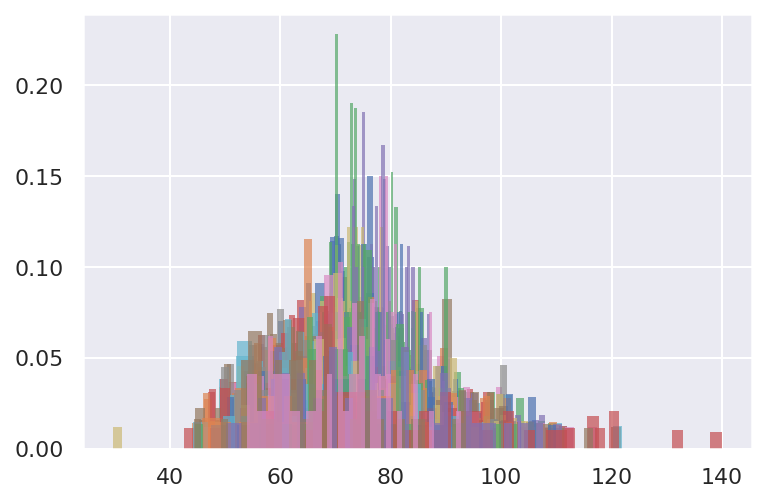

Loading model from file BDA-models/truncated_normal_L2_dp_mixture_model.p


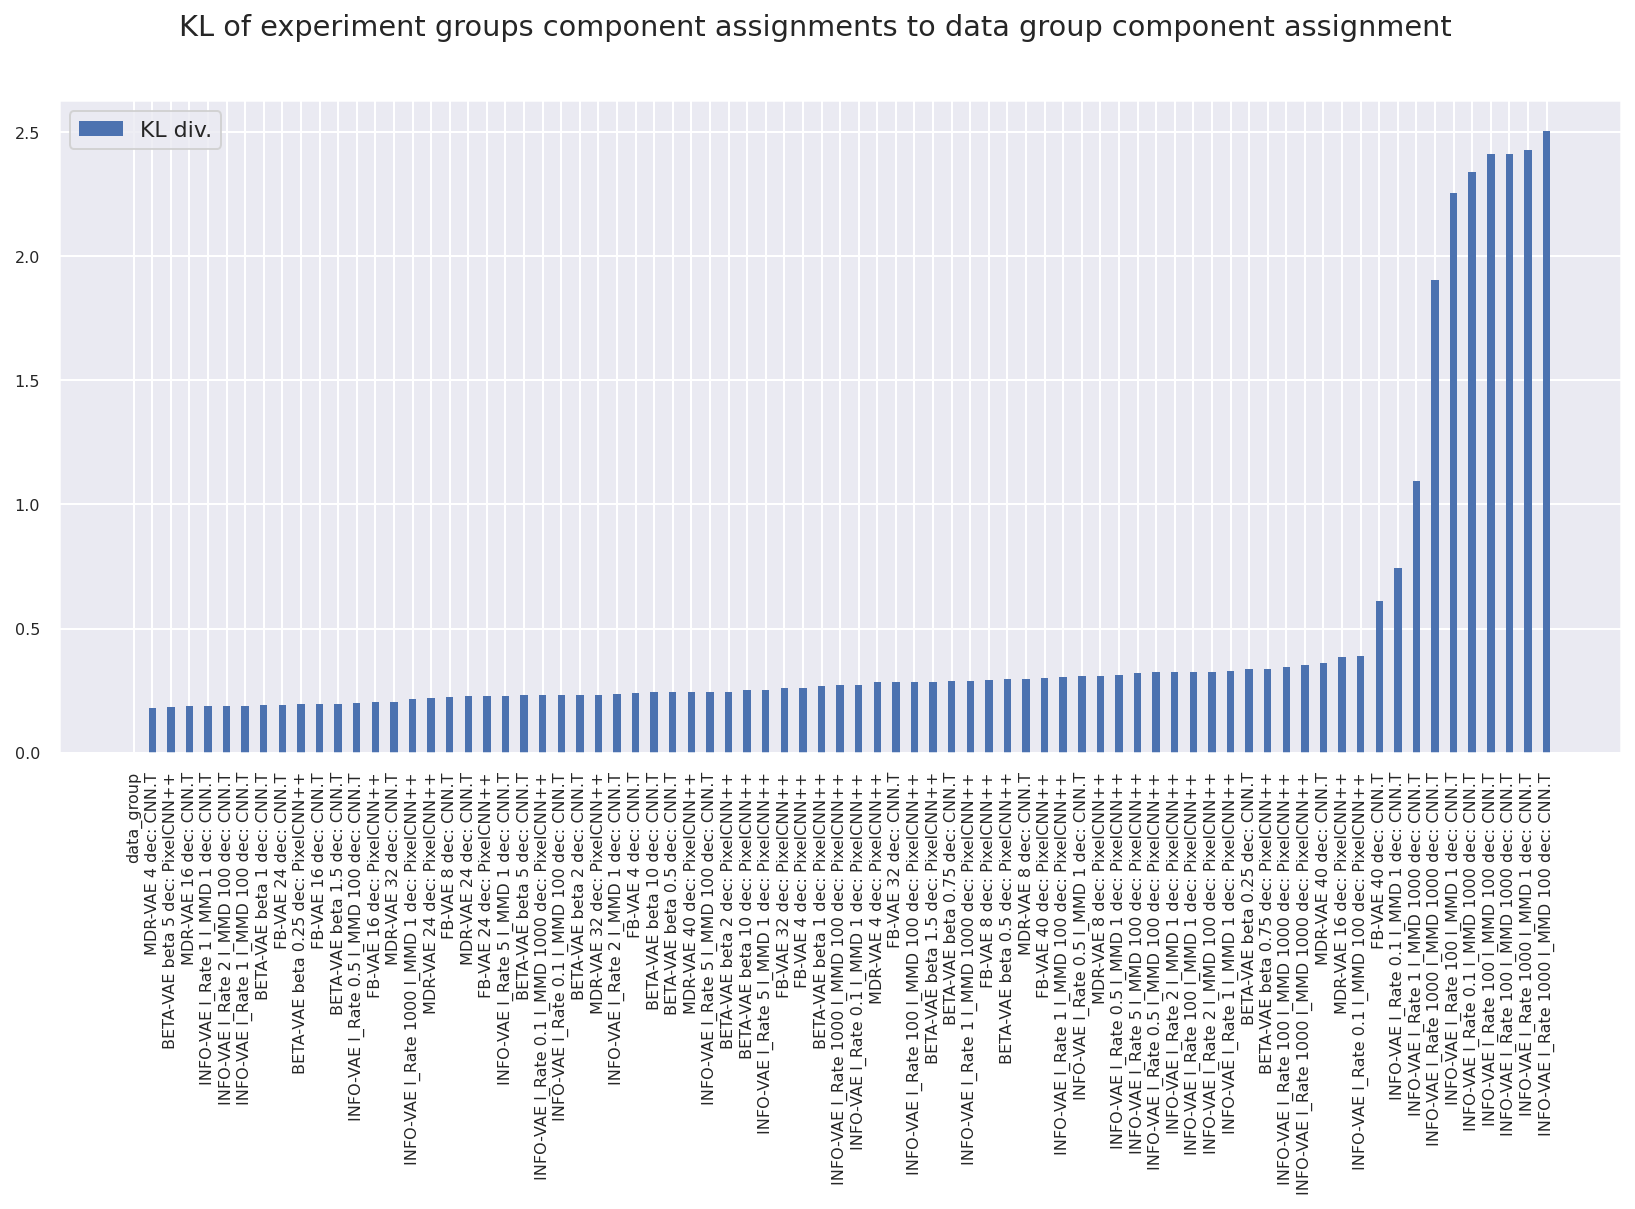

loc.shape (5,)


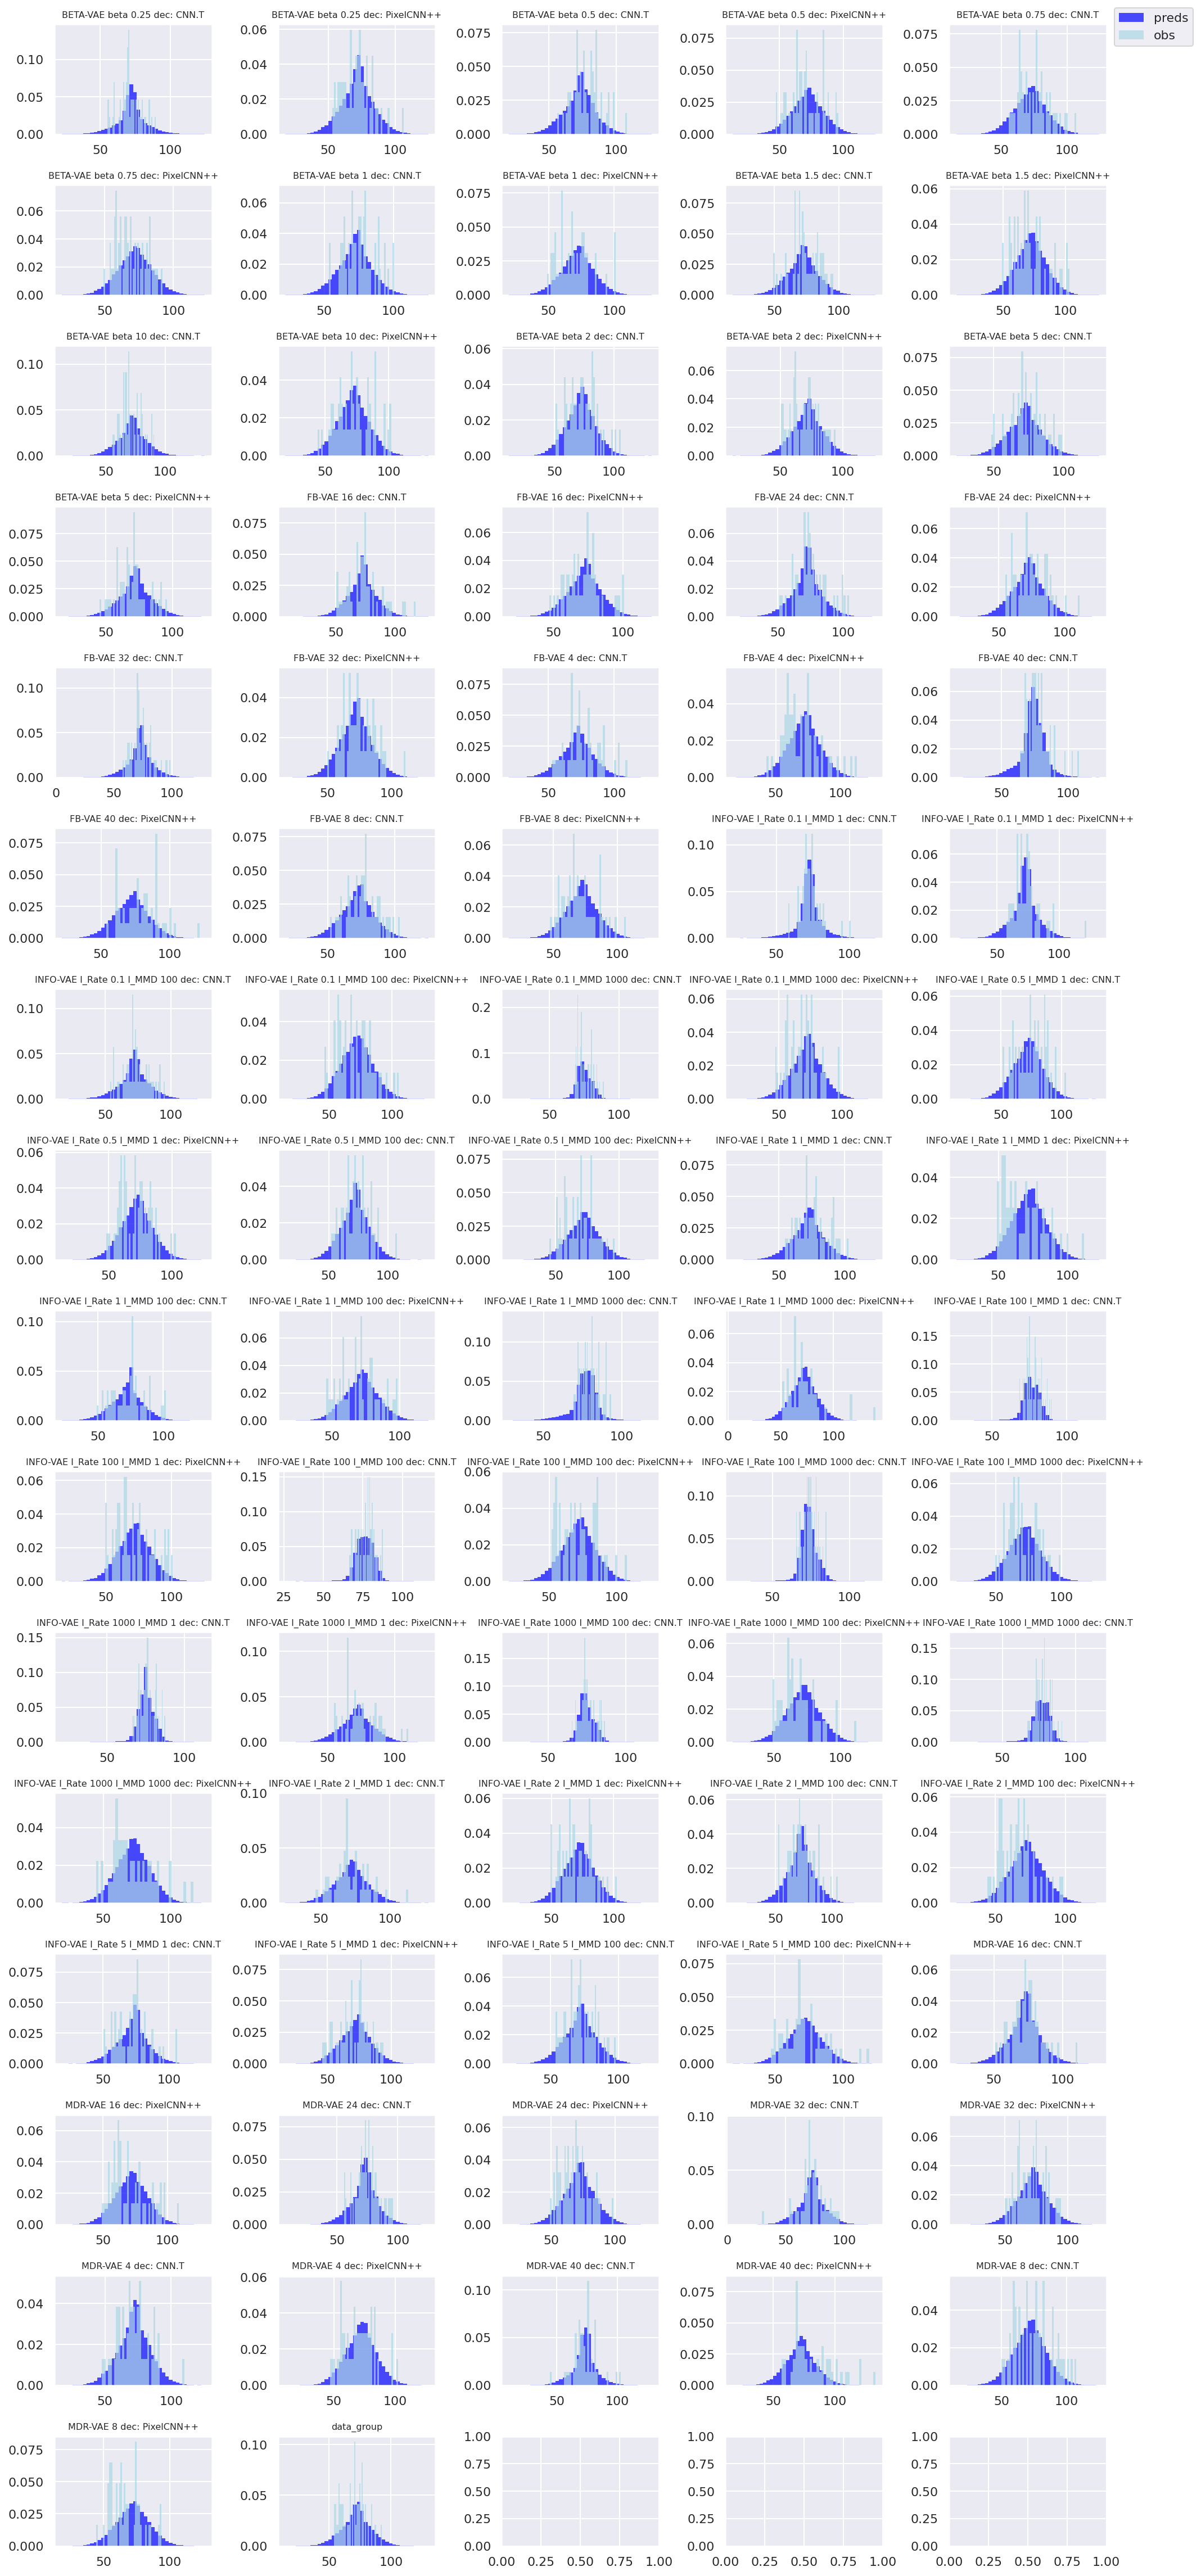

loc.shape (5,)


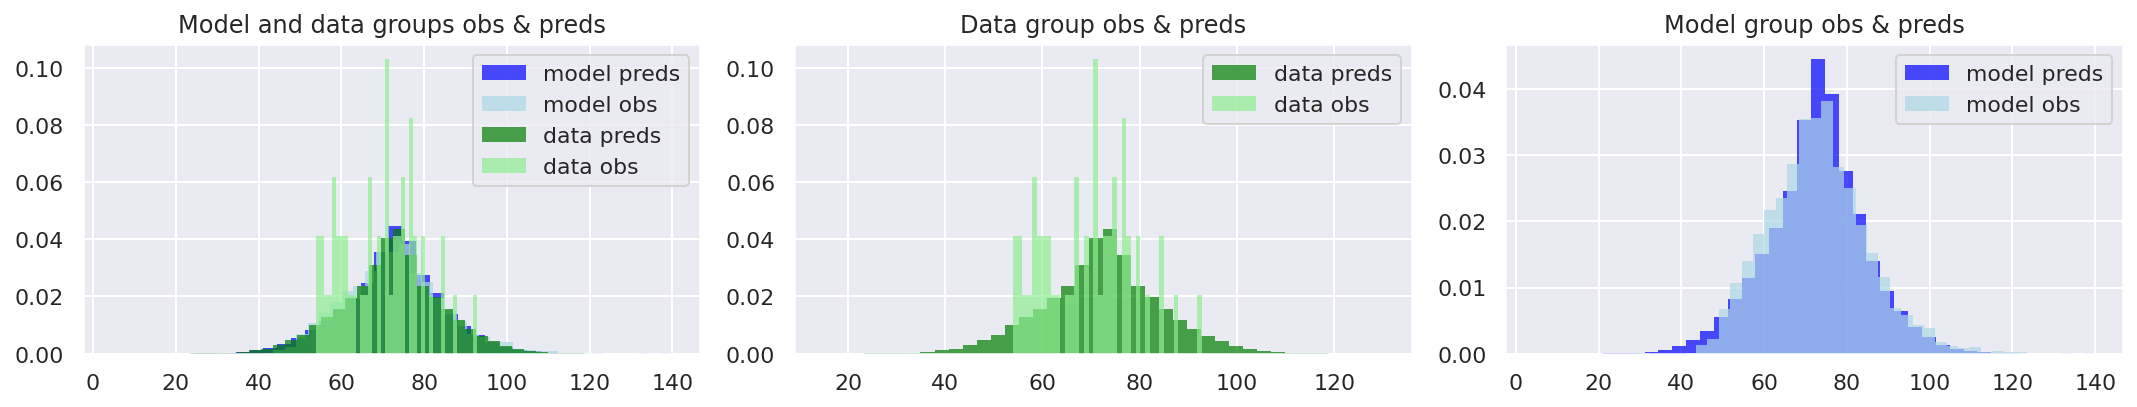

In [71]:
from scipy import stats

STAT = "L2"
DIST = "truncated_normal"
SAVE_FILE = f"{BDA_MODEL_DIR}/{DIST}_{STAT}_dp_mixture_model.p"
RUN = False
MAX_POINTS_PER_GROUP = 50

# 1 Prepare data
group_names, observations, mmds, elbos = [], [], [], []
for k, v in data.items():
    group_names.append(k)
    observations.append(v[STAT][:MAX_POINTS_PER_GROUP])
    if k == "data_group":
        mmds.append(0)
        elbos.append(0)
    else:
        mmds.append(v["MMD"])
        elbos.append(-v["ELBO"])

# 2 Plot data
for (g, o) in zip(group_names, observations):
    plt.hist(o, label=g, alpha=0.7, bins=40, density=True, lw=0)
#     print(g, type(o))
#     print(stats.describe(o.flatten()))
#     print("-"*40)
plt.show()

# 3 Run MCMC
if RUN or not os.path.isfile(SAVE_FILE):
    print("Running from scratch")
    dp_mixture_model_l2 = DPMixture(group_names, 
                                 observations, 
                                 obs_dist=DIST, 
                                 DP_alpha=1., 
                                 num_comps=5, 
                                 num_samples=1000, 
                                 num_chains=1, 
                                 num_warmup=100)
    dp_mixture_model_l2.run()
    pickle.dump(dp_mixture_model_l2, open(SAVE_FILE, "wb"))
else:
    print(f"Loading model from file {SAVE_FILE}")
    dp_mixture_model_l2 = pickle.load(open(SAVE_FILE, "rb"))

# 4 Plot results
plot_component_dist_and_data_group_distance(dp_mixture_model_l2)
plot_all_groups_preds_obs(dp_mixture_model_l2)
plot_model_data_preds_obs(dp_mixture_model_l2)

In [74]:
models = [dp_mixture_model_l0, dp_mixture_model_l2, dp_mixture_model_kl]
stat_names = ["L0", "L2", "KL"]

kl_results = dict()

for model, stat in zip(models, stat_names):

    # [N_s, N_g, N_c]
    omega = model.posterior_samples["omega"] 
    data_group_id = model.group_names.index("data_group")
    omega_data_group = omega[:, data_group_id, :]

    omega_tensor = torch.FloatTensor(np.array(omega))
    omega_data_group_tensor = torch.FloatTensor(np.array(omega_data_group)).unsqueeze(1)

    omega_dists = td.Categorical(probs=omega_tensor)
    omega_data_group_dists = td.Categorical(probs=omega_data_group_tensor)

    # [N_s, N_g, N_c] -> [N_s, N_g] -> [N_g]
    kl = td.kl_divergence(omega_data_group_dists, omega_dists)
    kl_avg = kl.mean(axis=0) # avg sample dim
    
    kl_results[stat] = dict(group_names=model.group_names, kl_div=kl_avg)
    
    

#     kl_order = np.argsort(kl_avg.numpy().flatten())
#     labels_reorder = np.array(self.group_names)[kl_order]

#     x = np.arange(len(kl_order))

#     fig, ax = plt.subplots(figsize=(14, 6))

#     if mmds is None:
#         ax.bar(x, kl_avg[kl_order], 0.4, lw=0, label="KL div.")
#     else:
#         mmds_reorder = np.array(mmds)[kl_order]
#         _ = ax.bar(x-0.2, kl_avg[kl_order], 0.4, lw=0, label="KL div.")
#         _ = ax.bar(x+0.2, mmds_reorder, 0.4, lw=0, label="MMD")

#     ax.set_xticks(x)
#     ax.set_xticklabels(labels_reorder)

#     ax.tick_params(axis='both', labelsize=8)

#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)

#     plt.legend()
#     _ = plt.suptitle(f"KL of experiment groups component assignments to data group component assignment")
#     plt.show()

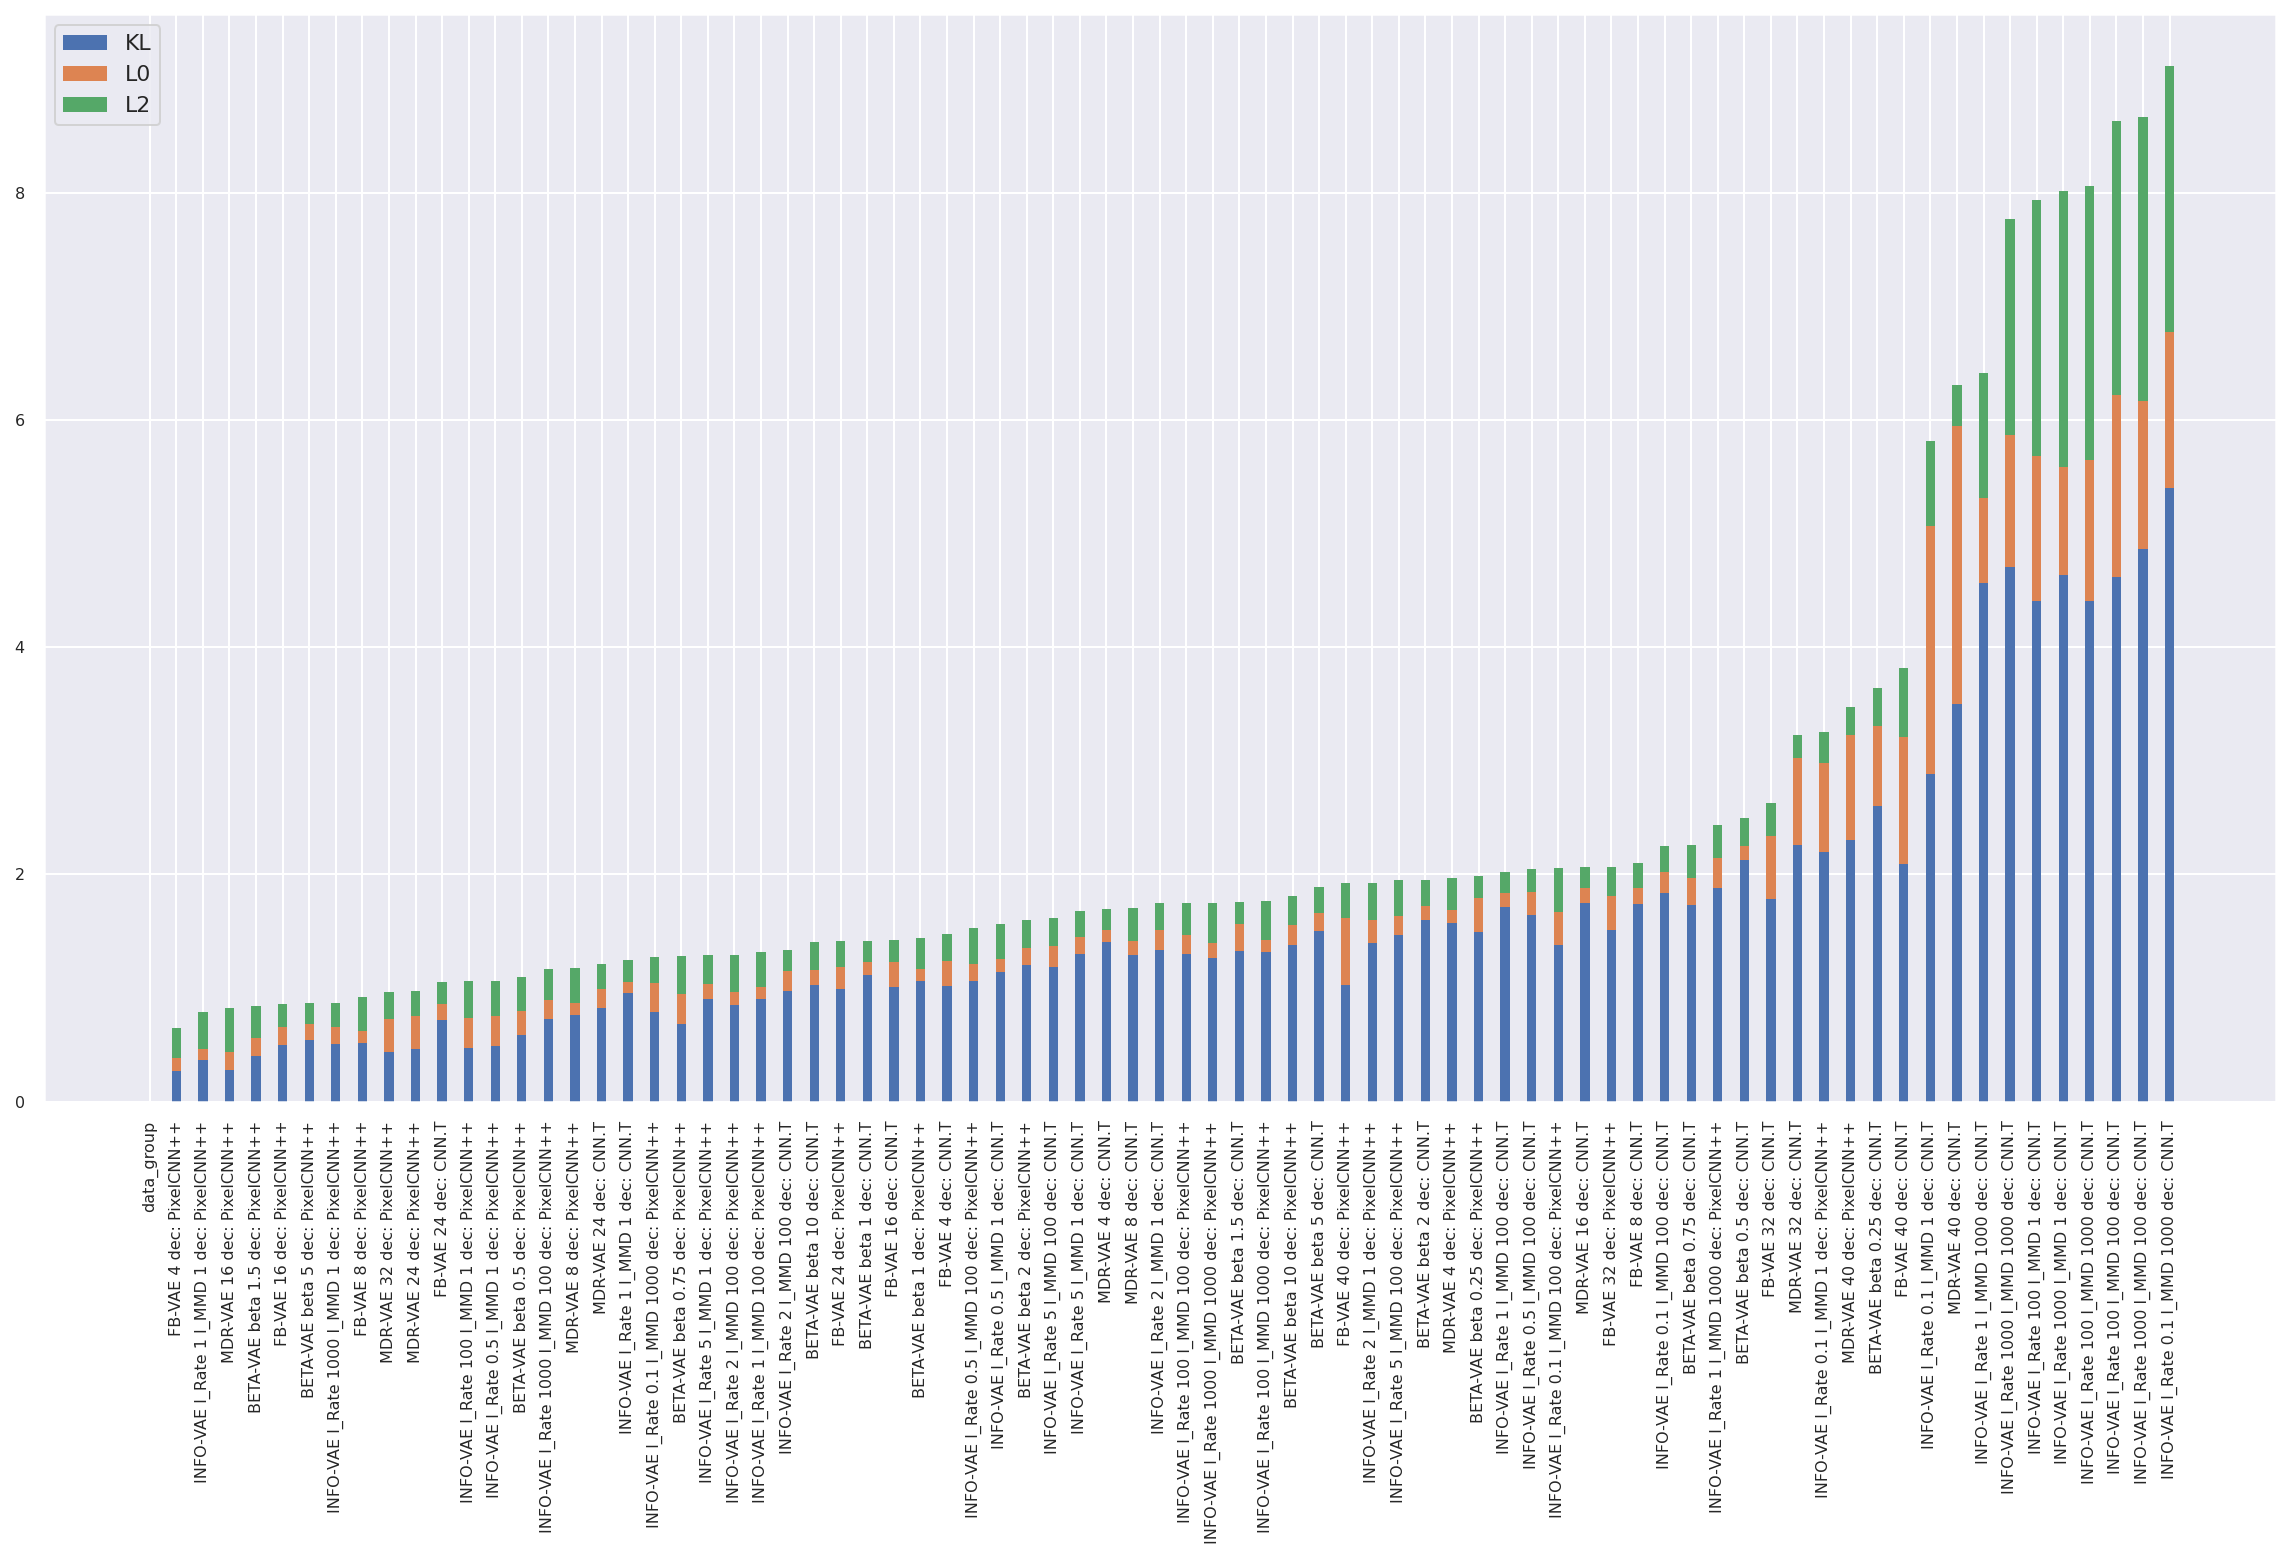

In [81]:
import matplotlib.pyplot as plt

labels = np.array(kl_results["KL"]["group_names"])
# men_means = [20, 35, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]
# men_std = [2, 3, 4, 1, 2]
# women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20, 10))

total = kl_results["KL"]["kl_div"]+kl_results["L0"]["kl_div"]+kl_results["L2"]["kl_div"]
total_order = np.argsort(total)

kl_ordered = kl_results["KL"]["kl_div"][total_order]
l2_ordered = kl_results["L2"]["kl_div"][total_order]
l0_ordered = kl_results["L0"]["kl_div"][total_order]
labels_reorders = labels[total_order]

ax.bar(labels_reorders, kl_ordered, width, 
       label="KL", lw=0)
ax.bar(labels_reorders, l0_ordered, width, bottom=kl_ordered, label='L0', lw=0)
ax.bar(labels_reorders, l2_ordered, width, bottom=kl_ordered+l0_ordered, label='L2', lw=0)

x = np.arange(len(kl_results["KL"]["kl_div"]))
ax.set_xticks(x)
ax.set_xticklabels(labels_reorders)

ax.tick_params(axis='both', labelsize=8)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

    

In [41]:
def predictive_checks(model, prior=False):
#     if prior:
#         if model.prior_predictions is None:
#             model.get_prior_predictions()
#         preds = np.array(model.prior_predictions["obs"])
#     else:
#         if model.posterior_predictions is None:
#             model.get_posterior_predictions()
#         preds = np.array(model.posterior_predictions["obs"]) #.reshape(-1, self.posterior_predictions["obs"].shape[-1])
#         preds = preds.reshape(model.num_chains, model.num_samples, model.N)
#         preds = preds[0, :, :]  # only consider the first chain, to make plotting less heavy
    
    if prior:
        preds = dp_mixture_model.draw_prior_predictions()
    else:
        preds = dp_mixture_model.draw_posterior_predictions()
    # print("predictive checks shape preds:", preds.shape)

    # SHAPES:
    # posterior_predictions [N_chains*N_samples, N_data]
    # prior_predictions [N_samples, N_data]
    # samples (generalising both): [N_s, N_d]

    obs_mean = np.mean(model.obs_y)
    obs_std = np.std(model.obs_y)
    obs_median = np.median(model.obs_y)
    obs_mode = np.max(model.obs_y)
    obs_skew = obs_mean ** (-0.5)
    obs_kurtosis = obs_mean ** (-1)

    obs_stats = [obs_mean, obs_std, obs_median, obs_mode, obs_skew, obs_kurtosis]

    pred_mean = np.mean(preds, axis=1)
    pred_std = np.std(preds, axis=1)
    pred_median = np.median(preds, axis=1)
    pred_mode = np.max(preds, axis=1)
    pred_skew = pred_mean ** (-0.5)
    pred_kurtosis = pred_mean ** (-1)

    preds_stats = [pred_mean, pred_std, pred_median, pred_mode, pred_skew, pred_kurtosis]
    preds_stats_means = [s.mean() for s in preds_stats]
    preds_stats_std = [s.std() for s in preds_stats]

    # predictive p values
    p_vals = [(p > o).mean() for p, o in zip(preds_stats, obs_stats)]

    stats = ["mean", "std", "median", "max", "skew", "kurtosis"]

    headers = ['check', 'p_val', 'obs', 'pred (mean)', 'pred (std)']
    rows = [['S', 1, None, preds.shape[0], None], ['shape', None, model.obs_y.shape, preds.shape, None]]

    for s, p_v, o, p_m, p_std in zip(stats, p_vals, obs_stats, preds_stats_means, preds_stats_std):
        rows.append([s, f"{p_v:.3f}", f"{o:.3f}", f"{p_m:.3f}", f"{p_std:.3f}"])

    for C in [0.25, 0.5, 0.75, 1., 2.]:
        mean_check = (np.abs(pred_mean - obs_mean) < C * pred_std)
        rows.append([f"mean within {C:.2f}*std", None, None, f"{mean_check.mean():.3f}", f"{mean_check.std():.3f}"])

    print(tabulate(rows, headers=headers))  # , floatfmt=(None, ".3f", ".3f", ".3f")

    ncols = 3
    nrows = int(np.ceil(len(stats) / ncols))

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4))

    for i, (s, o, p, pm) in enumerate(zip(stats, obs_stats, preds_stats, preds_stats_means)):
        r, c = i // ncols, i % ncols
        if np.any(np.isinf(p)) or np.any(np.isnan(p)):
            print(f"encountered NAN in preds of {s} = {np.any(np.isnan(p))}")
            print(f"encountered INF in preds of {s} = {np.any(np.isinf(p))}")
            continue

        axs[r, c].hist(np.array(p), bins=40, lw=0, density=True)
        axs[r, c].axvline(o, color='g', linestyle='dashed', label='obs')
        axs[r, c].axvline(pm, color='r', linestyle='dashed', label='pred mean T')
        axs[r, c].set_title(s)

    title = "Prior predictive checks" if prior else "Posterior predictive checkes"
    plt.suptitle(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

loc.shape (5,)
check                   p_val  obs      pred (mean)         pred (std)
--------------------  -------  -------  -------------  ---------------
S                       1               1000
shape                          (3850,)  (1000, 3850)
mean                    0.063  72.878   -1111.665      36021.7
std                     0.832  12.062   75491.234          2.23473e+06
median                  0      72.520   71.235             0.246
max                     0.763  139.986  65768.172          1.28807e+06
skew                    0.925  0.117    nan              nan
kurtosis                0.925  0.014    0.014              0.005
mean within 0.25*std                    1.000              0
mean within 0.50*std                    1.000              0
mean within 0.75*std                    1.000              0
mean within 1.00*std                    1.000              0
mean within 2.00*std                    1.000              0
encountered NAN in preds of skew = True
enco

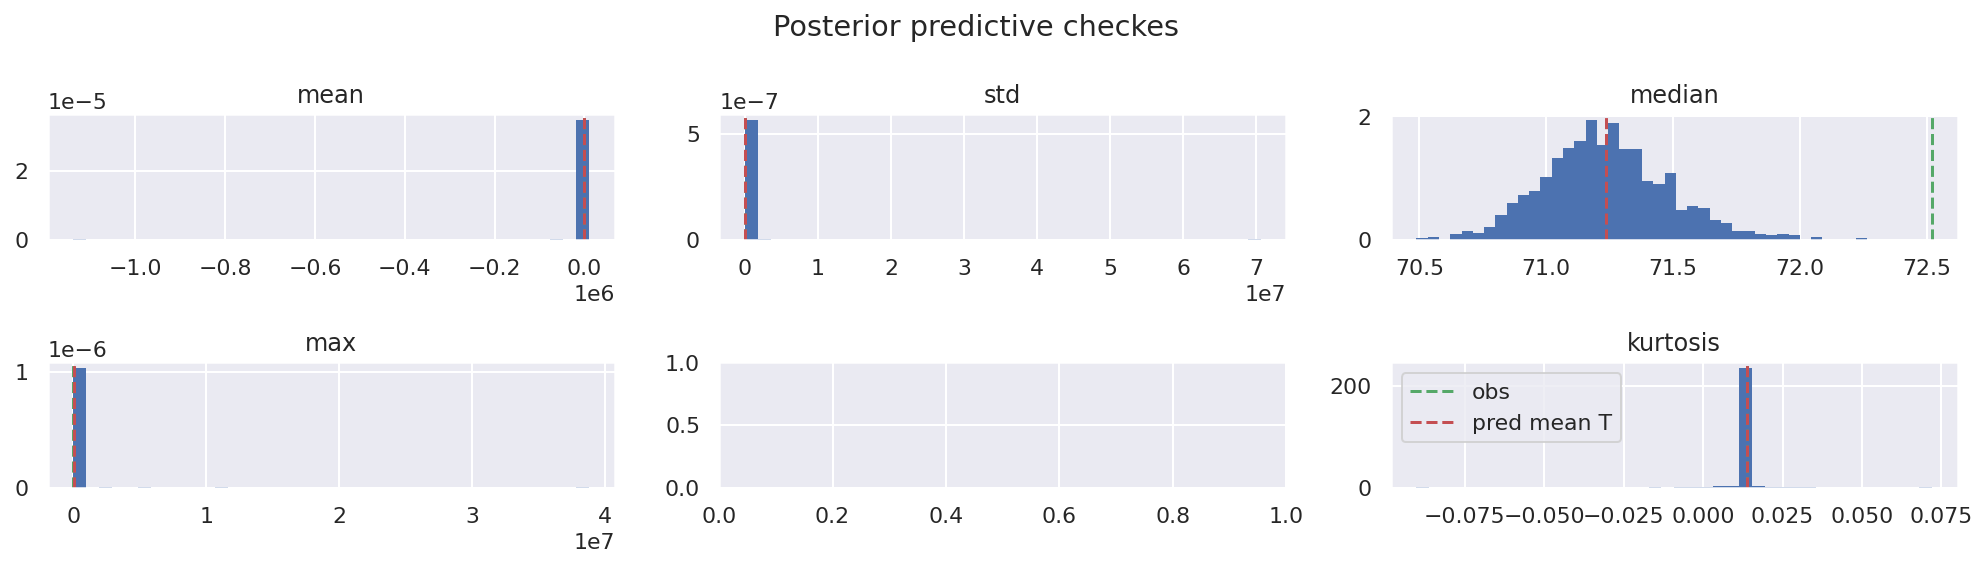

In [35]:
predictive_checks(dp_mixture_model)

loc.shape (5,)


(array([3.00000e+00, 2.00000e+00, 0.00000e+00, 4.00000e+00, 5.00000e+00,
        8.00000e+00, 8.00000e+00, 9.00000e+00, 1.20000e+01, 1.50000e+01,
        1.90000e+01, 2.90000e+01, 3.00000e+01, 3.30000e+01, 3.30000e+01,
        4.00000e+01, 1.08000e+02, 3.80000e+02, 3.83491e+05, 3.74000e+02,
        1.31000e+02, 6.00000e+01, 3.40000e+01, 2.80000e+01, 2.80000e+01,
        2.20000e+01, 2.00000e+01, 1.10000e+01, 1.50000e+01, 1.20000e+01,
        1.10000e+01, 7.00000e+00, 7.00000e+00, 4.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-1.43350890e+18, -1.35615249e+18, -1.27879593e+18, -1.20143952e+18,
        -1.12408303e+18, -1.04672655e+18, -9.69370064e+17, -8.92013580e+17,
        -8.14657165e+17, -7.37300680e+17, -6.59944196e+17, -5.82587712e+17,
        -5.05231262e+17, -4.27874778e+17, -3.50518328e+17, -2.73161844e+17,
        -1.95805377e+17, -1.18448902e+17, -4.10924346e+16,  3.62640367e+16,
         1.13620508e+17,  1.909769

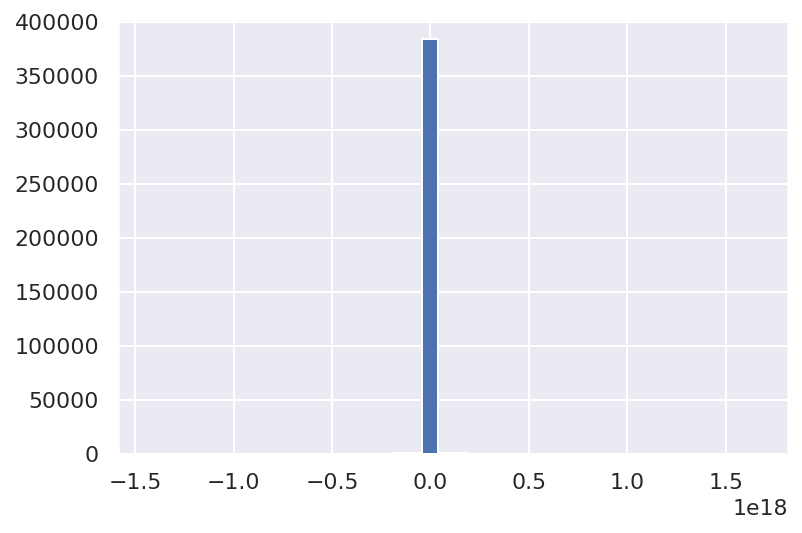

In [39]:
_ = plt.hist(dp_mixture_model.draw_prior_predictions().flatten(), bins=40)

In [ ]:
# def plot_component_dist_and_data_group_distance(self, mmds, elbos):
#     data_group_id = self.group_names.index("data_group")
#     data_group_omega_mean = omega_mean[data_group_id, :]

#     l2_distance = np.linalg.norm(omega_mean - data_group_omega_mean, axis=1)
#     l2_order = np.argsort(l2_distance)

#     omega_mean_reorder = omega_mean[l2_order, :]
#     labels_reorder = np.array(self.group_names)[l2_order]

#     fig, ax = plt.subplots(figsize=(4, 10))
#     ax.imshow(omega_mean_reorder)
#     ax.set_yticks(range(self.G))
#     ax.set_yticklabels(labels_reorder, size=8)
#     ax.set_xlabel("Component i")
#     ax.grid(None)

#     plt.show()

#     mmds_reorder = np.array(mmds)[l2_order]
#     elbos_reorder = np.array(elbos)[l2_order]

#     x = np.arange(len(l2_order))

#     fig, ax = plt.subplots(figsize=(14, 6))
#     _ = ax.bar(x-0.2, l2_distance[l2_order], 0.4, lw=0, label="L2")
#     _ = ax.bar(x+0.2, mmds_reorder, 0.4, lw=0, label="MMD")

#     ax.set_xticks(x)
#     ax.set_xticklabels(labels_reorder)

#     ax.tick_params(axis='both', labelsize=8)

#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)

#     plt.legend()
#     _ = plt.suptitle(f"L2 of experiment groups component assignments to data group component assignment")
#     plt.show()
    
#     other_groups_ids = np.array([i for i in range(len(self.group_names)) if i != data_group_id])
#     ncols = 4
#     nrows = int(np.ceil(len(other_groups_ids) / 4))
#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*2), sharex=True)
    
#     for idx, other_group_id in enumerate(other_groups_ids):
#         r, c = idx // ncols, idx % ncols
        
#         omega_samples_data = self.posterior_samples["omega"][:, data_group_id, :]
#         omega_samples_other_group = self.posterior_samples["omega"][:, other_group_id, :]
        
#         #print(omega_samples_data.shape)
#         #print(omega_samples_other_group.shape)
        
#         l2_dist = np.linalg.norm(omega_samples_data - omega_samples_other_group, axis=1)
#         l2_dist_mean = np.mean(l2_dist)
#         axs[r, c].hist(l2_dist, bins=40, density=True, lw=0, label="L2 dist")
#         axs[r, c].axvline(l2_distance[other_group_id], color="black", label="L2 of means")
#         axs[r, c].axvline(l2_dist_mean, color="orange", label="mean of L2")
#         axs[r, c].set_title(self.group_names[other_group_id], size=8)
#         if c + 1 == ncols:
#             axs[r, c].legend(loc=(1.07, 0.7))
    
#     plt.suptitle("Hist of L2 between component distributions of groups and data groups \nand L2 difference between mean component distribitions", y=1.01)
#     plt.tight_layout()
#     plt.show()